# Simulations of morphing LCE lattices


## Imports


In [1]:
import scipy.io
import pandas as pd
import numpy as np
from morphing_lattices.plotting import plot_lattice, generate_animation
from morphing_lattices.structure import ControlParams, Lattice
from morphing_lattices.dynamics import setup_dynamic_solver
from morphing_lattices.geometry import triangular_lattice_connectivity, triangular_lattice_points
from morphing_lattices.kinematics import build_strain_fn, rotation_matrix
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax._src.config import config
config.update("jax_enable_x64", True)  # enable float64 type
from jax import vmap
from pathlib import Path
%matplotlib widget
plt.style.use(["science", "grid"])


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Thermally responsive mass-spring lattice


### Import experimental data

In [2]:
exp_actuation_strain = pd.read_csv('../exp/mechanical_data/20230512_HTNI_LTNI_actuationstrains_highgranularityTemp3355.csv').drop(['Unnamed: 3'], axis=1)
exp_modulus_stress = pd.read_csv('../exp/mechanical_data/LTNI and HTNI LCE strains and moduli from Arda.csv')
exp_modulus_stress.drop(exp_modulus_stress.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, -1]], axis=1, inplace=True)
exp_modulus_stress.columns = exp_modulus_stress.iloc[0]
exp_modulus_stress.drop(0, inplace=True)

exp_modulus_fine = pd.read_csv('../exp/mechanical_data/youngs_mod_LCEstrips_DataForBertoldiGroup_updated202307.csv')
exp_modulus_fine.columns = ['Temp', 'LTNI_avg_young', 'LTNI_stdev', 'HTNI_avg_young', 'HTNI_stdev']
exp_modulus_fine.drop([0,1], inplace=True)
exp_modulus_fine = exp_modulus_fine.reset_index(drop=True)

HTNI_stretch_data = exp_actuation_strain[['temp [C]', 'AVG HTNI', 'STD HTNI']].astype(float)
LTNI_stretch_data = exp_actuation_strain[['temp [C]', 'AVG LTNI', 'STD LTNI']].astype(float)

HTNI_modulus_data = exp_modulus_stress[['Temp [C] corresponding to HTNI data', 'Avg Youngs Modulus of HTNI [Mpa]']].dropna().astype(float)
LTNI_modulus_data = exp_modulus_stress[['Temp [C] corresponding to LTNI data', 'Avg Youngs Modulus of LTNI [Mpa]']].dropna().astype(float)

LTNI_modulus_data_fine = exp_modulus_fine[['Temp', 'LTNI_avg_young']].astype(float)
HTNI_modulus_data_fine = exp_modulus_fine[['Temp', 'HTNI_avg_young']].astype(float)

sampled_temps = jnp.array([22, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130])
ts = jnp.linspace(0, 1*9000, len(sampled_temps)) # used for interpolation

# Experimental tracking data
LTNI_all_x_posi = scipy.io.loadmat('../exp/tracking_data/20230609_F1_LTNI/LTNI_x_positions_transformed.mat')['LTNI_x_positions_transformed'] # [mm] <num nodes x num sampled temps>
LTNI_all_y_posi = scipy.io.loadmat('../exp/tracking_data/20230609_F1_LTNI/LTNI_y_positions_transformed.mat')['LTNI_y_positions_transformed'] # [mm] <num nodes x num sampled temps>
HTNI_all_x_posi = scipy.io.loadmat('../exp/tracking_data/20230609_G1_HTNI/HTNI_x_positions_transformed.mat')['HTNI_x_positions_transformed'] # [mm] <num nodes x num sampled temps>
HTNI_all_y_posi = scipy.io.loadmat('../exp/tracking_data/20230609_G1_HTNI/HTNI_y_positions_transformed.mat')['HTNI_y_positions_transformed'] # [mm] <num nodes x num sampled temps>

LTNI_teeth_x_posi = scipy.io.loadmat('../exp/tracking_data/20230609_E1_LTNIteeth/LTNI_teeth_x_positions_transformed.mat')['LTNI_teeth_x_positions_transformed'] # [mm] <num nodes x num sampled temps>
LTNI_teeth_y_posi = scipy.io.loadmat('../exp/tracking_data/20230609_E1_LTNIteeth/LTNI_teeth_y_positions_transformed.mat')['LTNI_teeth_y_positions_transformed'] # [mm] <num nodes x num sampled temps>
HTNI_teeth_x_posi = scipy.io.loadmat('../exp/tracking_data/20230609_B2_HTNIteeth/HTNI_teeth_x_positions_transformed.mat')['HTNI_teeth_x_positions_transformed'] # [mm] <num nodes x num sampled temps>
HTNI_teeth_y_posi = scipy.io.loadmat('../exp/tracking_data/20230609_B2_HTNIteeth/HTNI_teeth_y_positions_transformed.mat')['HTNI_teeth_y_positions_transformed'] # [mm] <num nodes x num sampled temps>

LTNI_pacman_x_posi = scipy.io.loadmat('../exp/tracking_data/20230609_H1_LTNIpacman/LTNI_pacman_x_positions_transformed.mat')['LTNI_pacman_x_positions_transformed'] # [mm] <num nodes x num sampled temps>
LTNI_pacman_y_posi = scipy.io.loadmat('../exp/tracking_data/20230609_H1_LTNIpacman/LTNI_pacman_y_positions_transformed.mat')['LTNI_pacman_y_positions_transformed'] # [mm] <num nodes x num sampled temps>
HTNI_pacman_x_posi = scipy.io.loadmat('../exp/tracking_data/20230609_J1_HTNIpacman/HTNI_pacman_x_positions_transformed.mat')['HTNI_pacman_x_positions_transformed'] # [mm] <num nodes x num sampled temps>
HTNI_pacman_y_posi = scipy.io.loadmat('../exp/tracking_data/20230609_J1_HTNIpacman/HTNI_pacman_y_positions_transformed.mat')['HTNI_pacman_y_positions_transformed'] # [mm] <num nodes x num sampled temps>

bilayer_x_posi = scipy.io.loadmat('../exp/tracking_data/bilayer/bilayer_x_pos_transformed.mat')['bilayer_x_pos_transformed'] # [mm] <num nodes x num sampled temps>
bilayer_y_posi = scipy.io.loadmat('../exp/tracking_data/bilayer/bilayer_y_pos_transformed.mat')['bilayer_y_pos_transformed'] # [mm] <num nodes x num sampled temps>

HTNIaltpac_x_posi = scipy.io.loadmat('../exp/tracking_data/alternating_HTNI_pacman/HTNIaltpac_x_pos_transformed.mat')['HTNIaltpac_x_pos_transformed'] # [mm] <num nodes x num sampled temps>
HTNIaltpac_y_posi = scipy.io.loadmat('../exp/tracking_data/alternating_HTNI_pacman/HTNIaltpac_y_pos_transformed.mat')['HTNIaltpac_y_pos_transformed'] # [mm] <num nodes x num sampled temps>

In [3]:
# rotate the experimental data

def find_rotated_positions(x_positions, y_positions):

    n_temps = x_positions.shape[1]

    x_positions_rotated = jnp.zeros_like(x_positions)
    y_positions_rotated = jnp.zeros_like(y_positions)

    for i in jnp.arange(n_temps):
        x_pos_i = x_positions[:, i]
        y_pos_i = y_positions[:, i]

        five_low_yind = jnp.argsort(y_pos_i)[:5]

        bottom_row_xvals = x_pos_i[five_low_yind]

        max_bottom_row_xvals_ind = jnp.argmax(bottom_row_xvals)
        nodeXind = five_low_yind[max_bottom_row_xvals_ind]

        rotation_angle = -jnp.arctan(y_pos_i[nodeXind] / x_pos_i[nodeXind]) # angle in radians

        OGpts = jnp.array([x_pos_i, y_pos_i])
        rot_pts = jnp.dot(rotation_matrix(rotation_angle), OGpts)

        x_positions_rotated = x_positions_rotated.at[:, i].set(rot_pts[0, :])
        y_positions_rotated = y_positions_rotated.at[:, i].set(rot_pts[1, :])

    return x_positions_rotated, y_positions_rotated

def find_rotated_positions_bilayer(x_positions, y_positions):

    n_temps = x_positions.shape[1]

    x_positions_rotated = jnp.zeros_like(x_positions)
    y_positions_rotated = jnp.zeros_like(y_positions)

    for i in jnp.arange(n_temps):
        if i > 5 and i < 17:
            x_pos_i = x_positions[:, i]
            y_pos_i = y_positions[:, i]

            hundred_high_xind = jnp.argsort(x_pos_i)[-100:]

            far_yvals = y_pos_i[hundred_high_xind]

            lowest_far_yind = jnp.where(y_pos_i == jnp.min(far_yvals))[0][0]
            nodeXind1 = lowest_far_yind

            rotation_angle = -jnp.arctan((y_pos_i[nodeXind1]) / (x_pos_i[nodeXind1])) # angle in radians

            OGpts = jnp.array([x_pos_i, y_pos_i])
            rot_pts = jnp.dot(rotation_matrix(rotation_angle), OGpts)

            x_positions_rotated = x_positions_rotated.at[:, i].set(rot_pts[0, :])
            y_positions_rotated = y_positions_rotated.at[:, i].set(rot_pts[1, :])

        if i < 6:
            x_pos_i = x_positions[:, i]
            y_pos_i = y_positions[:, i]

            ten_low_yind = jnp.argsort(y_pos_i)[:10]

            bottom_row_xvals = x_pos_i[ten_low_yind]

            max_bottom_row_xvals_ind = jnp.argmax(bottom_row_xvals)
            min_bottom_row_xvals_ind = jnp.argmin(bottom_row_xvals)
            nodeXind1 = ten_low_yind[max_bottom_row_xvals_ind]
            nodeXind2 = ten_low_yind[min_bottom_row_xvals_ind]

            rotation_angle = -jnp.arctan((y_pos_i[nodeXind1]-y_pos_i[nodeXind2]) / (x_pos_i[nodeXind1]-x_pos_i[nodeXind2])) # angle in radians

            OGpts = jnp.array([x_pos_i, y_pos_i])
            rot_pts = jnp.dot(rotation_matrix(rotation_angle), OGpts)

            x_positions_rotated = x_positions_rotated.at[:, i].set(rot_pts[0, :])
            y_positions_rotated = y_positions_rotated.at[:, i].set(rot_pts[1, :])

        if i > 16:
            x_pos_i = x_positions[:, i]
            y_pos_i = y_positions[:, i]

            ten_low_yind = jnp.argsort(y_pos_i)[:10]

            bottom_row_xvals = x_pos_i[ten_low_yind]

            max_bottom_row_xvals_ind = jnp.argmax(bottom_row_xvals)
            min_bottom_row_xvals_ind = jnp.argmin(bottom_row_xvals)
            nodeXind1 = ten_low_yind[max_bottom_row_xvals_ind]
            nodeXind2 = ten_low_yind[min_bottom_row_xvals_ind]

            rotation_angle = -jnp.arctan((y_pos_i[nodeXind1]-y_pos_i[nodeXind2]) / (x_pos_i[nodeXind1]-x_pos_i[nodeXind2])) # angle in radians

            OGpts = jnp.array([x_pos_i, y_pos_i])
            rot_pts = jnp.dot(rotation_matrix(rotation_angle), OGpts)

            x_positions_rotated = x_positions_rotated.at[:, i].set(rot_pts[0, :])
            y_positions_rotated = y_positions_rotated.at[:, i].set(rot_pts[1, :])

    return x_positions_rotated, y_positions_rotated


def find_rotated_positions_HTNIaltpac(x_positions, y_positions):

    n_temps = x_positions.shape[1]

    x_positions_rotated = jnp.zeros_like(x_positions)
    y_positions_rotated = jnp.zeros_like(y_positions)

    for i in jnp.arange(n_temps):
        x_pos_i = x_positions[:, i]
        y_pos_i = y_positions[:, i]

        nine_low_yind = jnp.argsort(y_pos_i)[:9]

        bottom_row_xvals = x_pos_i[nine_low_yind]

        max_bottom_row_xvals_ind = jnp.argmax(bottom_row_xvals)
        nodeXind = nine_low_yind[max_bottom_row_xvals_ind]

        rotation_angle = -jnp.arctan(y_pos_i[nodeXind] / x_pos_i[nodeXind]) # angle in radians

        OGpts = jnp.array([x_pos_i, y_pos_i])
        rot_pts = jnp.dot(rotation_matrix(rotation_angle), OGpts)

        x_positions_rotated = x_positions_rotated.at[:, i].set(rot_pts[0, :])
        y_positions_rotated = y_positions_rotated.at[:, i].set(rot_pts[1, :])

    return x_positions_rotated, y_positions_rotated

LTNI_teeth_x_posj, LTNI_teeth_y_posj = find_rotated_positions(LTNI_teeth_x_posi, LTNI_teeth_y_posi)
HTNI_teeth_x_posj, HTNI_teeth_y_posj = find_rotated_positions(HTNI_teeth_x_posi, HTNI_teeth_y_posi)

LTNI_pacman_x_posj, LTNI_pacman_y_posj = find_rotated_positions(LTNI_pacman_x_posi, LTNI_pacman_y_posi)
HTNI_pacman_x_posj, HTNI_pacman_y_posj = find_rotated_positions(HTNI_pacman_x_posi, HTNI_pacman_y_posi)

HTNI_all_x_posj, HTNI_all_y_posj = find_rotated_positions(HTNI_all_x_posi, HTNI_all_y_posi)
LTNI_all_x_posj, LTNI_all_y_posj = find_rotated_positions(LTNI_all_x_posi, LTNI_all_y_posi)

bilayer_x_posj, bilayer_y_posj = find_rotated_positions_bilayer(bilayer_x_posi, bilayer_y_posi)

HTNIaltpac_x_posj, HTNIaltpac_y_posj = find_rotated_positions_HTNIaltpac(HTNIaltpac_x_posi, HTNIaltpac_y_posi)

In [4]:
origin_at_central_node = True # if True, the central node will be plotted at the origin. if False, the bottom left node will be plotted at the origin

def central_node_centering(x_positions, y_positions):

    x_positions_recentered = jnp.zeros_like(x_positions)
    y_positions_recentered = jnp.zeros_like(y_positions)

    n_temps = x_positions.shape[1]

    for j in jnp.arange(n_temps):

        avg_xpos = jnp.mean(x_positions[:, j])
        avg_ypos = jnp.mean(y_positions[:, j])

        central_x_index = jnp.argmin(jnp.abs(x_positions[:, j] - avg_xpos))
        central_y_index = jnp.argmin(jnp.abs(y_positions[:, j] - avg_ypos))

        x_positions_recentered = x_positions_recentered.at[:, j].set(x_positions[:, j] - x_positions[central_x_index, j])
        y_positions_recentered = y_positions_recentered.at[:, j].set(y_positions[:, j] - y_positions[central_y_index, j])

    return x_positions_recentered, y_positions_recentered


def central_node_centering_bilayer(x_positions, y_positions):

    x_positions_recentered = jnp.zeros_like(x_positions)
    y_positions_recentered = jnp.zeros_like(y_positions)

    n_temps = x_positions.shape[1]

    for j in jnp.arange(n_temps):

        avg_x_val = jnp.mean(x_positions[:, j])
        shifted_x_vals = jnp.abs(x_positions[:, j] - avg_x_val)

        three_middle_xvals = jnp.sort(shifted_x_vals)[:3]

        three_middle_xidxs = jnp.zeros_like(three_middle_xvals)
        three_middle_yvals = jnp.zeros_like(three_middle_xvals)
        for i in jnp.arange(3):
            three_middle_xidxs = three_middle_xidxs.at[i].set(jnp.where(shifted_x_vals == three_middle_xvals[i])[0][0])
            three_middle_yvals = three_middle_yvals.at[i].set(y_positions[jnp.where(shifted_x_vals == three_middle_xvals[i])[0][0], j])

        middle_yidx = int(three_middle_xidxs[jnp.argmin(jnp.abs(three_middle_yvals - jnp.mean(three_middle_yvals)))])

        x_shift = x_positions[middle_yidx, j]
        y_shift = y_positions[middle_yidx, j]

        x_positions_recentered = x_positions_recentered.at[:, j].set(x_positions[:, j] - x_shift)
        y_positions_recentered = y_positions_recentered.at[:, j].set(y_positions[:, j] - y_shift)

    return x_positions_recentered, y_positions_recentered

def central_node_centering_HTNIaltpac(x_positions, y_positions):

    x_positions_recentered = jnp.zeros_like(x_positions)
    y_positions_recentered = jnp.zeros_like(y_positions)

    n_temps = x_positions.shape[1]

    for j in jnp.arange(n_temps):

        nodes_to_ignore = jnp.arange(8*9 + 8*10) # ignore bottom half

        ten_middley_values = jnp.sort(y_positions[:, j])[int(nodes_to_ignore[-1]+1):int(nodes_to_ignore[-1]+11)]

        ten_middley_idxs = jnp.zeros_like(ten_middley_values)
        for i in jnp.arange(ten_middley_values.shape[0]):
            ten_middley_idxs = ten_middley_idxs.at[i].set(jnp.where(y_positions[:, j] == ten_middley_values[i])[0][0])
            
        ten_middlex_vals = jnp.zeros_like(ten_middley_values)
        for i, idx in enumerate(ten_middley_idxs):
            ten_middlex_vals = ten_middlex_vals.at[i].set(x_positions[int(idx), j])

        two_middlex_vals_OI = jnp.sort(ten_middlex_vals)[4:6]

        middle_x_idx1 = jnp.where(x_positions[:, j] == two_middlex_vals_OI[0])[0][0]
        middle_x_idx2 = jnp.where(x_positions[:, j] == two_middlex_vals_OI[1])[0][0]

        x_shift = (x_positions[middle_x_idx1, j] + x_positions[middle_x_idx2, j])/2
        y_shift = (y_positions[middle_x_idx1, j] + y_positions[middle_x_idx2, j])/2

        x_positions_recentered = x_positions_recentered.at[:, j].set(x_positions[:, j] - x_shift)
        y_positions_recentered = y_positions_recentered.at[:, j].set(y_positions[:, j] - y_shift)

    return x_positions_recentered, y_positions_recentered

if origin_at_central_node:

    LTNI_teeth_x_pos, LTNI_teeth_y_pos = central_node_centering(LTNI_teeth_x_posj, LTNI_teeth_y_posj)
    HTNI_teeth_x_pos, HTNI_teeth_y_pos = central_node_centering(HTNI_teeth_x_posj, HTNI_teeth_y_posj)

    LTNI_pacman_x_pos, LTNI_pacman_y_pos = central_node_centering(LTNI_pacman_x_posj, LTNI_pacman_y_posj)
    HTNI_pacman_x_pos, HTNI_pacman_y_pos = central_node_centering(HTNI_pacman_x_posj, HTNI_pacman_y_posj)

    HTNI_all_x_pos, HTNI_all_y_pos = central_node_centering(HTNI_all_x_posj, HTNI_all_y_posj)
    LTNI_all_x_pos, LTNI_all_y_pos = central_node_centering(LTNI_all_x_posj, LTNI_all_y_posj)

    bilayer_x_pos, bilayer_y_pos = central_node_centering_bilayer(bilayer_x_posj, bilayer_y_posj)
    HTNIaltpac_x_pos, HTNIaltpac_y_pos = central_node_centering_HTNIaltpac(HTNIaltpac_x_posj, HTNIaltpac_y_posj)

else:

    LTNI_all_x_pos = LTNI_all_x_posj
    LTNI_all_y_pos = LTNI_all_y_posj
    HTNI_all_x_pos = HTNI_all_x_posj
    HTNI_all_y_pos = HTNI_all_y_posj

    LTNI_teeth_x_pos = LTNI_teeth_x_posj
    LTNI_teeth_y_pos = LTNI_teeth_y_posj
    HTNI_teeth_x_pos = HTNI_teeth_x_posj
    HTNI_teeth_y_pos = HTNI_teeth_y_posj

    LTNI_pacman_x_pos = LTNI_pacman_x_posj
    LTNI_pacman_y_pos = LTNI_pacman_y_posj
    HTNI_pacman_x_pos = HTNI_pacman_x_posj
    HTNI_pacman_y_pos = HTNI_pacman_y_posj

    bilayer_x_pos = bilayer_x_posj
    bilayer_y_pos = bilayer_y_posj

    HTNIaltpac_x_pos = HTNIaltpac_x_posj
    HTNIaltpac_y_pos = HTNIaltpac_y_posj


In [5]:
def T(time):
    return jnp.interp(time, ts, sampled_temps)

def HTNI_stretch(temperature): # normalized length
    return jnp.interp(temperature, jnp.array(HTNI_stretch_data['temp [C]']), jnp.array(HTNI_stretch_data['AVG HTNI']))

def LTNI_stretch(temperature): # normalized length
    return jnp.interp(temperature, jnp.array(LTNI_stretch_data['temp [C]']), jnp.array(LTNI_stretch_data['AVG LTNI']))

def LTNI_young_fit(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_modulus_data['Temp [C] corresponding to LTNI data']), jnp.array(LTNI_modulus_data['Avg Youngs Modulus of LTNI [Mpa]']))

def HTNI_young_fit(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_modulus_data['Temp [C] corresponding to HTNI data']), jnp.array(HTNI_modulus_data['Avg Youngs Modulus of HTNI [Mpa]']))

def LTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_modulus_data_fine['Temp']), jnp.array(LTNI_modulus_data_fine['LTNI_avg_young']))

def HTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_modulus_data_fine['Temp']), jnp.array(HTNI_modulus_data_fine['HTNI_avg_young']))


## Use experimental material parameters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Lattice'}, xlabel='$x$', ylabel='$y$'>)

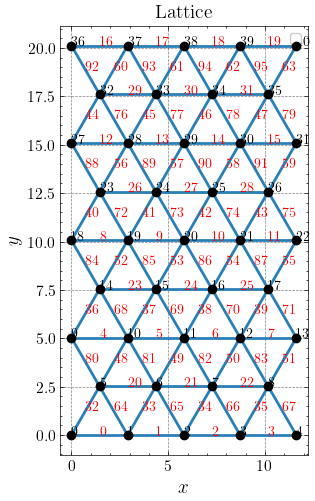

In [6]:
n1 = 4
n2 = 8

spacing = LTNI_all_x_pos[3, 0] - LTNI_all_x_pos[4, 0] # needs to be manually determined bc of inconsistent indexing in experimental data
points = triangular_lattice_points(n1=n1, n2=n2, spacing=spacing)
connectivity, horiz_bonds_even, horiz_bonds_odd, right_lean_even, right_lean_odd, left_lean_even, left_lean_odd = triangular_lattice_connectivity(n1=n1, n2=n2)

n_points = points.shape[0]
n_bonds = connectivity.shape[0]

control_params = ControlParams(
    reference_points=points,
    young=jnp.ones(n_bonds),
    area=jnp.ones(n_bonds)*(4*0.125**2),
    thermal_strain=-0.25*jnp.ones(n_bonds),
    damping=0.03*jnp.ones((n_points, 2)),
    masses=1.*jnp.ones((n_points, 2)),
)
lattice = Lattice(
    connectivity=connectivity,
    control_params=control_params
)
plot_lattice(lattice, annotate=True, figsize=(5, 5))

In [7]:
horizontal_bonds_indices = jnp.arange(0, len(horiz_bonds_even)+len(horiz_bonds_odd))
right_leaning_indices = jnp.arange(horizontal_bonds_indices[-1]+1, horizontal_bonds_indices[-1]+1 + len(right_lean_even) + len(right_lean_odd))
left_leaning_indices = jnp.arange(right_leaning_indices[-1]+1, right_leaning_indices[-1]+1 + len(left_lean_even) + len(left_lean_odd))


def HTNI_all_young(t):
    young = jnp.ones(n_bonds)*HTNI_young_fit_fine(T(t))
    return young

def HTNI_all_thermalstrain(t):
    thermal_strain = jnp.ones(n_bonds)*(HTNI_stretch(T(t))-1)*0.8
    return thermal_strain

def LTNI_all_young(t):
    young = jnp.ones(n_bonds)*LTNI_young_fit_fine(T(t))
    return young

def LTNI_all_thermalstrain(t):
    thermal_strain = jnp.ones(n_bonds)*(LTNI_stretch(T(t))-1)*0.7
    return thermal_strain

def HTNI_teeth_young(t):
    young = jnp.ones(n_bonds)

    young = young.at[horizontal_bonds_indices].set(LTNI_young_fit_fine(T(t)))
    young = young.at[jnp.concatenate([right_leaning_indices, left_leaning_indices])].set(HTNI_young_fit_fine(T(t)))

    return young

def HTNI_teeth_thermalstrain(t):
    thermal_strain = jnp.ones(n_bonds)

    thermal_strain = thermal_strain.at[horizontal_bonds_indices].set((LTNI_stretch(T(t))-1)*0.7)
    thermal_strain = thermal_strain.at[jnp.concatenate([right_leaning_indices, left_leaning_indices])].set((HTNI_stretch(T(t))-1)*0.8)

    return thermal_strain

def LTNI_teeth_young(t):
    young = jnp.ones(n_bonds)

    young = young.at[horizontal_bonds_indices].set(HTNI_young_fit_fine(T(t)))
    young = young.at[jnp.concatenate([right_leaning_indices, left_leaning_indices])].set(LTNI_young_fit_fine(T(t)))

    return young

def LTNI_teeth_thermalstrain(t):
    thermal_strain = jnp.ones(n_bonds)

    thermal_strain = thermal_strain.at[horizontal_bonds_indices].set((HTNI_stretch(T(t))-1)*0.8)
    thermal_strain = thermal_strain.at[jnp.concatenate([right_leaning_indices, left_leaning_indices])].set((LTNI_stretch(T(t))-1)*0.7)

    return thermal_strain

def HTNI_pacman_young(t):
    young = jnp.ones(n_bonds)

    young = young.at[jnp.concatenate([horizontal_bonds_indices, right_leaning_indices])].set(HTNI_young_fit_fine(T(t)))
    young = young.at[left_leaning_indices].set(LTNI_young_fit_fine(T(t)))

    return young

def HTNI_pacman_thermalstrain(t):
    thermal_strain = jnp.ones(n_bonds)

    thermal_strain = thermal_strain.at[jnp.concatenate([horizontal_bonds_indices, right_leaning_indices])].set((HTNI_stretch(T(t))-1)*0.8)
    thermal_strain = thermal_strain.at[left_leaning_indices].set((LTNI_stretch(T(t))-1)*0.7)

    return thermal_strain

def LTNI_pacman_young(t):
    young = jnp.ones(n_bonds)

    young = young.at[jnp.concatenate([horizontal_bonds_indices, right_leaning_indices])].set(LTNI_young_fit_fine(T(t)))
    young = young.at[left_leaning_indices].set(HTNI_young_fit_fine(T(t)))

    return young

def LTNI_pacman_thermalstrain(t):
    thermal_strain = jnp.ones(n_bonds)

    thermal_strain = thermal_strain.at[jnp.concatenate([horizontal_bonds_indices, right_leaning_indices])].set((LTNI_stretch(T(t))-1)*0.7)
    thermal_strain = thermal_strain.at[left_leaning_indices].set((HTNI_stretch(T(t))-1)*0.8)

    return thermal_strain


def strut_properties(lattice_name: str):
    if lattice_name == 'HTNI_all':
        youngs_modulus_fn = HTNI_all_young
        thermal_strain_fn = HTNI_all_thermalstrain
    elif lattice_name == 'LTNI_all':
        youngs_modulus_fn = LTNI_all_young
        thermal_strain_fn = LTNI_all_thermalstrain
    elif lattice_name == 'HTNI_teeth':
        youngs_modulus_fn = HTNI_teeth_young
        thermal_strain_fn = HTNI_teeth_thermalstrain
    elif lattice_name == 'LTNI_teeth':
        youngs_modulus_fn = LTNI_teeth_young
        thermal_strain_fn = LTNI_teeth_thermalstrain
    elif lattice_name == 'HTNI_pacman':
        youngs_modulus_fn = HTNI_pacman_young
        thermal_strain_fn = HTNI_pacman_thermalstrain
    elif lattice_name == 'LTNI_pacman':
        youngs_modulus_fn = LTNI_pacman_young
        thermal_strain_fn = LTNI_pacman_thermalstrain

    return youngs_modulus_fn, thermal_strain_fn


In [ ]:
# Choose lattice topology:
# 'HTNI_all', 'LTNI_all', 'HTNI_teeth', 'LTNI_teeth', 'HTNI_pacman', 'LTNI_pacman'
lattice_topology = 'LTNI_all'
youngs_modulus_fn, thermal_strain_fn = strut_properties(lattice_topology)

# Initial conditions
state0 = jnp.array([
    0*lattice.control_params.reference_points,  # Initial displacements
    0*lattice.control_params.reference_points,  # Initial velocities
])
timepoints = jnp.linspace(0, ts[-1], 9001)
temp_evolution = T(timepoints) # used for plotting

def control_params_fn(t, control_params: ControlParams):
    return control_params._replace(
        young = youngs_modulus_fn(t),
        thermal_strain = thermal_strain_fn(t)
    )


solve_dynamics, _ = setup_dynamic_solver(
    lattice=lattice,
    control_params_fn=control_params_fn,
    constrained_point_DOF_pairs=jnp.array([[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [
                                          2, 1], [3, 0], [3, 1], [4, 0], [4, 1]]),
    rigid_bodies_points=[jnp.arange(lattice.n_points-n1-1, lattice.n_points)],  # Last row is a rigid body
)
lattice.solution = solve_dynamics(state0, timepoints, lattice.control_params)

strain_fn = build_strain_fn(lattice.connectivity)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 500x500 with 2 Axes>,
 <Axes: title={'center': 'Final state'}, xlabel='$x$', ylabel='$y$'>)

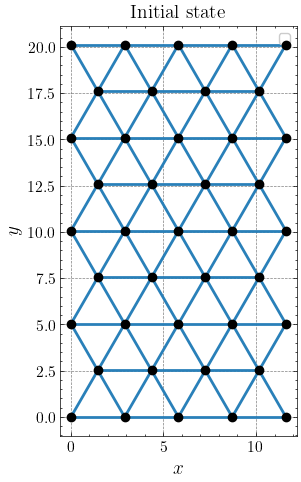

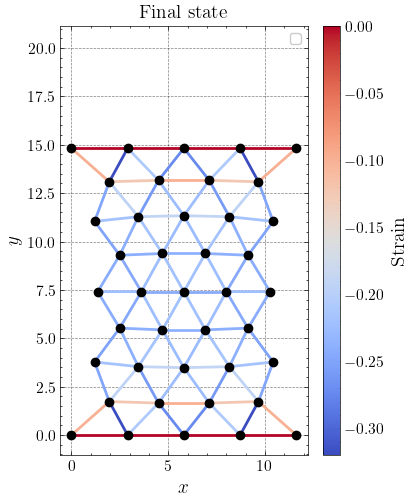

In [9]:
plot_lattice(lattice, lattice.solution[0, 0], title='Initial state', figsize=(3, 6))
plot_lattice(lattice, lattice.solution[-1, 0], title='Final state', figsize=(5, 5),
             bond_values=strain_fn(lattice.control_params.reference_points, lattice.solution[-1, 0]),
             legend_label='Strain')


## Plot the periodic lattices' response to increasing temperature

In [ ]:
plot_lattice_stretch_evolution = False

### HTNI all Numerical and Experimental comparison

In [11]:
if plot_lattice_stretch_evolution and lattice_topology == 'HTNI_all':
    HTNI_all_lattice_stretch_vs_temp = jnp.zeros([2, len(sampled_temps)])
    for counter in jnp.arange(len(sampled_temps)):
        temp_i = sampled_temps[counter]
        timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

        # Calculate strain data
        top_central_node_idx = 38
        bottom_central_node_idx = 2
        left_central_node_idx = 18
        right_central_node_idx = 22

        l0_x = lattice.control_params.reference_points[right_central_node_idx, 0] - lattice.control_params.reference_points[left_central_node_idx, 0]
        l0_y = lattice.control_params.reference_points[top_central_node_idx, 1] - lattice.control_params.reference_points[bottom_central_node_idx, 1]

        l_x = (l0_x + (lattice.solution[timepoint_near_temp_i, 0, right_central_node_idx, 0] - lattice.solution[timepoint_near_temp_i, 0, left_central_node_idx, 0])) / l0_x
        l_y = (l0_y + (lattice.solution[timepoint_near_temp_i, 0, top_central_node_idx, 1] - lattice.solution[timepoint_near_temp_i, 0, bottom_central_node_idx, 1])) / l0_y

        HTNI_all_lattice_stretch_vs_temp = HTNI_all_lattice_stretch_vs_temp.at[:, counter].set(jnp.array([l_x, l_y]))


    # Plot the stretch over temperature
    plt.figure(figsize=[3,4])
    plt.plot(sampled_temps, HTNI_all_lattice_stretch_vs_temp[0, :], 'ko-', label='$\lambda_x$')
    plt.plot(sampled_temps, HTNI_all_lattice_stretch_vs_temp[1, :], color='#A52A2A', linestyle='-', marker='o', label='$\lambda_y$')
    plt.legend()
    plt.xlabel('Temperature [$^\circ$C]')
    plt.ylabel('Stretch')
    plt.title('HTNI_all Lattice Stretch')
    plt.tight_layout()
    np.savetxt('HTNI_all_lattice_stretch_vs_temp.csv', (HTNI_all_lattice_stretch_vs_temp[0,:], HTNI_all_lattice_stretch_vs_temp[1,:]), delimiter=',')

    
    dir_path = f'..\out\periodic_lattices'
    out_path_png = Path(f"{dir_path}/{lattice_topology}_stretch_evolution.png")
    out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_png), dpi=200)
    out_path_svg = Path(f"{dir_path}/{lattice_topology}_stretch_evolution.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

In [12]:
if lattice_topology == 'HTNI_all':
    fig, ax = plt.subplots(4, 6, figsize = [12, 12])

    counter = -1
    for i in jnp.arange(ax.shape[0]):
        for j in jnp.arange(ax.shape[1]):
            counter+=1

            if counter < len(sampled_temps):
                temp_i = sampled_temps[counter]
                exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
                timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

                if origin_at_central_node:
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - (lattice.control_params.reference_points[20, :] + lattice.solution[timepoint_near_temp_i, 0, 20, :])
                else:
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0]

                for pair in lattice.connectivity:
                    ax[i, j].plot(*pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

                ax[i, j].plot(pts[:, 0], pts[:, 1], 'bo', label='Num.')
                ax[i, j].plot(HTNI_all_x_pos[:, exp_idx_i], HTNI_all_y_pos[:, exp_idx_i], 'ro', label='Exp.')
                ax[i, j].set_ylim([min(HTNI_all_y_pos[:, 0]) - 3, max(HTNI_all_y_pos[:, 0]) + 3])
                ax[i, j].set_xlim([min(HTNI_all_x_pos[:, 0]) - 3, max(HTNI_all_x_pos[:, 0]) + 3])
                ax[i, j].legend(fontsize=7, loc='upper right')
                ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

    plt.suptitle('HTNI Numerical vs Experimental', fontsize=18)
    plt.tight_layout()

    dir_path = f'..\out\periodic_lattices'
    if origin_at_central_node:
        out_path_png = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_central_node_centering.png")
        out_path_svg = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_central_node_centering.svg")
    else:
        out_path_png = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_corner_node_centering.png")
        out_path_svg = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_corner_node_centering.svg")
    out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_png), dpi=200)
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

### LTNI all Numerical and Experimental Comparison

In [17]:
if plot_lattice_stretch_evolution and lattice_topology == 'LTNI_all':
    LTNI_all_lattice_stretch_vs_temp = jnp.zeros([2, len(sampled_temps)])
    for counter in jnp.arange(len(sampled_temps)):
        temp_i = sampled_temps[counter]
        timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

        # Calculate strain data
        top_central_node_idx = 38
        bottom_central_node_idx = 2
        left_central_node_idx = 18
        right_central_node_idx = 22

        l0_x = lattice.control_params.reference_points[right_central_node_idx, 0] - lattice.control_params.reference_points[left_central_node_idx, 0]
        l0_y = lattice.control_params.reference_points[top_central_node_idx, 1] - lattice.control_params.reference_points[bottom_central_node_idx, 1]

        l_x = (l0_x + (lattice.solution[timepoint_near_temp_i, 0, right_central_node_idx, 0] - lattice.solution[timepoint_near_temp_i, 0, left_central_node_idx, 0])) / l0_x
        l_y = (l0_y + (lattice.solution[timepoint_near_temp_i, 0, top_central_node_idx, 1] - lattice.solution[timepoint_near_temp_i, 0, bottom_central_node_idx, 1])) / l0_y

        LTNI_all_lattice_stretch_vs_temp = LTNI_all_lattice_stretch_vs_temp.at[:, counter].set(jnp.array([l_x, l_y]))


    # Plot the stretch over temperature
    plt.figure(figsize=[3,4])
    plt.plot(sampled_temps, LTNI_all_lattice_stretch_vs_temp[0, :], 'ko-', label='$\lambda_x$')
    plt.plot(sampled_temps, LTNI_all_lattice_stretch_vs_temp[1, :], color='#A52A2A', linestyle='-', marker='o', label='$\lambda_y$')
    plt.legend()
    plt.xlabel('Temperature [$^\circ$C]')
    plt.ylabel('Stretch')
    plt.title('LTNI_all Lattice Stretch')
    plt.tight_layout()
    np.savetxt('LTNI_all_lattice_stretch_vs_temp.csv', (LTNI_all_lattice_stretch_vs_temp[0,:], LTNI_all_lattice_stretch_vs_temp[1,:]), delimiter=',')

    dir_path = f'..\out\periodic_lattices'
    out_path_png = Path(f"{dir_path}/{lattice_topology}_stretch_evolution.png")
    out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_png), dpi=200)
    out_path_svg = Path(f"{dir_path}/{lattice_topology}_stretch_evolution.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

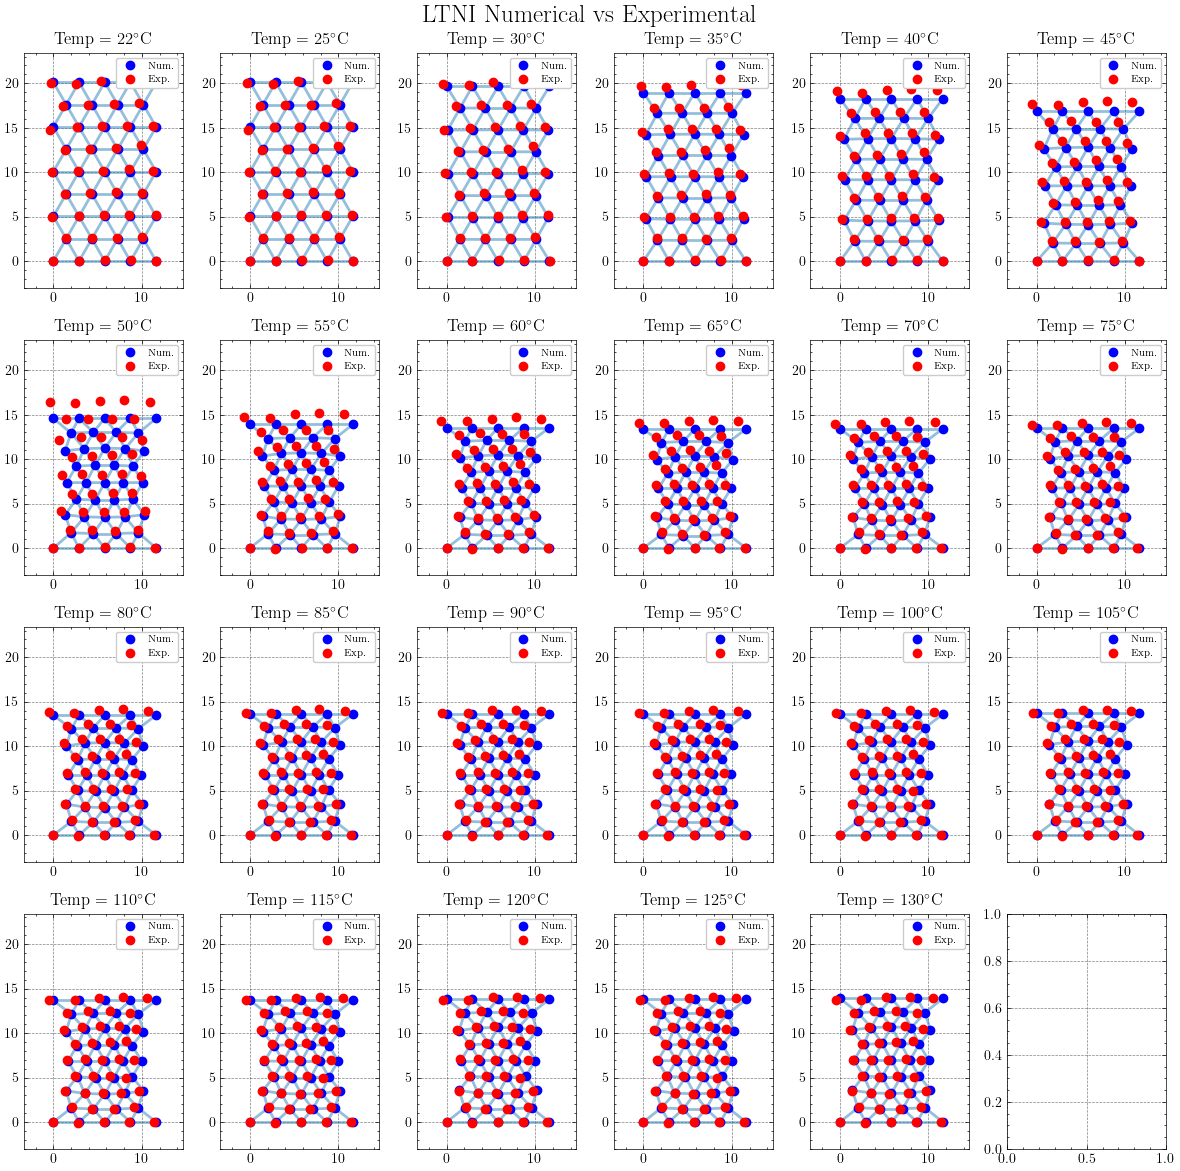

In [18]:
if lattice_topology == 'LTNI_all':
    fig, ax = plt.subplots(4, 6, figsize = [12, 12])

    counter = -1
    for i in jnp.arange(ax.shape[0]):
        for j in jnp.arange(ax.shape[1]):
            counter+=1

            if counter < len(sampled_temps):
                temp_i = sampled_temps[counter]
                exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
                timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

                if origin_at_central_node:
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - (lattice.control_params.reference_points[20, :] + lattice.solution[timepoint_near_temp_i, 0, 20, :])
                else:
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0]

                for pair in lattice.connectivity:
                    ax[i, j].plot(*pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

                ax[i, j].plot(pts[:, 0], pts[:, 1], 'bo', label='Num.')
                ax[i, j].plot(LTNI_all_x_pos[:, exp_idx_i], LTNI_all_y_pos[:, exp_idx_i], 'ro', label='Exp.')
                ax[i, j].set_ylim([min(LTNI_all_y_pos[:, 0]) - 3, max(LTNI_all_y_pos[:, 0]) + 3])
                ax[i, j].set_xlim([min(LTNI_all_x_pos[:, 0]) - 3, max(LTNI_all_x_pos[:, 0]) + 3])
                ax[i, j].legend(fontsize=7, loc='upper right')
                ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

    plt.suptitle('LTNI Numerical vs Experimental', fontsize=18)
    plt.tight_layout()

    dir_path = f'..\out\periodic_lattices'
    if origin_at_central_node:
        out_path_png = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_central_node_centering.png")
        out_path_svg = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_central_node_centering.svg")
    else:
        out_path_png = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_corner_node_centering.png")
        out_path_svg = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_corner_node_centering.svg")
    out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_png), dpi=200)
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

### HTNI teeth Numerical and Experimental Comparison

In [15]:
if plot_lattice_stretch_evolution and lattice_topology == 'HTNI_teeth':
    HTNI_teeth_lattice_stretch_vs_temp = jnp.zeros([2, len(sampled_temps)])
    for counter in jnp.arange(len(sampled_temps)):
        temp_i = sampled_temps[counter]
        timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

        # Calculate strain data
        top_central_node_idx = 38
        bottom_central_node_idx = 2
        left_central_node_idx = 18
        right_central_node_idx = 22

        l0_x = lattice.control_params.reference_points[right_central_node_idx, 0] - lattice.control_params.reference_points[left_central_node_idx, 0]
        l0_y = lattice.control_params.reference_points[top_central_node_idx, 1] - lattice.control_params.reference_points[bottom_central_node_idx, 1]

        l_x = (l0_x + (lattice.solution[timepoint_near_temp_i, 0, right_central_node_idx, 0] - lattice.solution[timepoint_near_temp_i, 0, left_central_node_idx, 0])) / l0_x
        l_y = (l0_y + (lattice.solution[timepoint_near_temp_i, 0, top_central_node_idx, 1] - lattice.solution[timepoint_near_temp_i, 0, bottom_central_node_idx, 1])) / l0_y

        HTNI_teeth_lattice_stretch_vs_temp = HTNI_teeth_lattice_stretch_vs_temp.at[:, counter].set(jnp.array([l_x, l_y]))


    # Plot the stretch over temperature
    plt.figure(figsize=[3,4])
    plt.plot(sampled_temps, HTNI_teeth_lattice_stretch_vs_temp[0, :], 'ko-', label='$\lambda_x$')
    plt.plot(sampled_temps, HTNI_teeth_lattice_stretch_vs_temp[1, :], color='#A52A2A', linestyle='-', marker='o', label='$\lambda_y$')
    plt.legend()
    plt.xlabel('Temperature [$^\circ$C]')
    plt.ylabel('Stretch')
    plt.title('HTNI_teeth Lattice Stretch')
    plt.tight_layout()
    np.savetxt('HTNI_teeth_lattice_stretch_vs_temp.csv', (HTNI_teeth_lattice_stretch_vs_temp[0,:], HTNI_teeth_lattice_stretch_vs_temp[1,:]), delimiter=',')

    dir_path = f'..\out\periodic_lattices'
    out_path_png = Path(f"{dir_path}/{lattice_topology}_stretch_evolution.png")
    out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_png), dpi=200)
    out_path_svg = Path(f"{dir_path}/{lattice_topology}_stretch_evolution.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

In [16]:
if lattice_topology == 'HTNI_teeth':
    fig, ax = plt.subplots(4, 6, figsize = [12, 12])

    counter = -1
    for i in jnp.arange(ax.shape[0]):
        for j in jnp.arange(ax.shape[1]):
            counter+=1

            if counter < len(sampled_temps):
                temp_i = sampled_temps[counter]
                exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
                timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

                if origin_at_central_node:
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - (lattice.control_params.reference_points[20, :] + lattice.solution[timepoint_near_temp_i, 0, 20, :])
                else:
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0]

                for pair in lattice.connectivity:
                    ax[i, j].plot(*pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

                ax[i, j].plot(pts[:, 0], pts[:, 1], 'bo', label='Num.')
                ax[i, j].plot(HTNI_teeth_x_pos[:, exp_idx_i], HTNI_teeth_y_pos[:, exp_idx_i], 'ro', label='Exp.')
                ax[i, j].set_ylim([min(HTNI_teeth_y_pos[:, 0]) - 3, max(HTNI_teeth_y_pos[:, 0]) + 3])
                ax[i, j].set_xlim([min(HTNI_teeth_x_pos[:, 0]) - 3, max(HTNI_teeth_x_pos[:, 0]) + 3])
                ax[i, j].legend(fontsize=7, loc='upper right')
                ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

    plt.suptitle('HTNI Teeth Numerical vs Experimental', fontsize=18)
    plt.tight_layout()

    dir_path = f'..\out\periodic_lattices'
    if origin_at_central_node:
        out_path_png = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_central_node_centering.png")
        out_path_svg = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_central_node_centering.svg")
    else:
        out_path_png = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_corner_node_centering.png")
        out_path_svg = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_corner_node_centering.svg")
    out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_png), dpi=200)
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

### LTNI teeth Numerical and Experimental Comparison

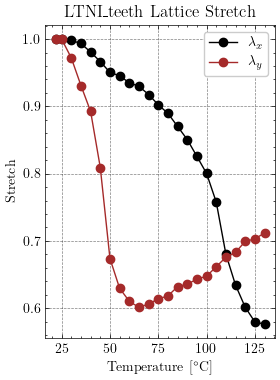

In [17]:
if plot_lattice_stretch_evolution and lattice_topology == 'LTNI_teeth':
    LTNI_teeth_lattice_stretch_vs_temp = jnp.zeros([2, len(sampled_temps)])
    for counter in jnp.arange(len(sampled_temps)):
        temp_i = sampled_temps[counter]
        timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

        # Calculate strain data
        top_central_node_idx = 38
        bottom_central_node_idx = 2
        left_central_node_idx = 18
        right_central_node_idx = 22

        l0_x = lattice.control_params.reference_points[right_central_node_idx, 0] - lattice.control_params.reference_points[left_central_node_idx, 0]
        l0_y = lattice.control_params.reference_points[top_central_node_idx, 1] - lattice.control_params.reference_points[bottom_central_node_idx, 1]

        l_x = (l0_x + (lattice.solution[timepoint_near_temp_i, 0, right_central_node_idx, 0] - lattice.solution[timepoint_near_temp_i, 0, left_central_node_idx, 0])) / l0_x
        l_y = (l0_y + (lattice.solution[timepoint_near_temp_i, 0, top_central_node_idx, 1] - lattice.solution[timepoint_near_temp_i, 0, bottom_central_node_idx, 1])) / l0_y

        LTNI_teeth_lattice_stretch_vs_temp = LTNI_teeth_lattice_stretch_vs_temp.at[:, counter].set(jnp.array([l_x, l_y]))


    # Plot the stretch over temperature
    plt.figure(figsize=[3,4])
    plt.plot(sampled_temps, LTNI_teeth_lattice_stretch_vs_temp[0, :], 'ko-', label='$\lambda_x$')
    plt.plot(sampled_temps, LTNI_teeth_lattice_stretch_vs_temp[1, :], color='#A52A2A', linestyle='-', marker='o', label='$\lambda_y$')
    plt.legend()
    plt.xlabel('Temperature [$^\circ$C]')
    plt.ylabel('Stretch')
    plt.title('LTNI_teeth Lattice Stretch')
    plt.tight_layout()
    np.savetxt('LTNI_teeth_lattice_stretch_vs_temp.csv', (LTNI_teeth_lattice_stretch_vs_temp[0,:], LTNI_teeth_lattice_stretch_vs_temp[1,:]), delimiter=',')

    dir_path = f'..\out\periodic_lattices'
    out_path_png = Path(f"{dir_path}/{lattice_topology}_stretch_evolution.png")
    out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_png), dpi=200)
    out_path_svg = Path(f"{dir_path}/{lattice_topology}_stretch_evolution.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

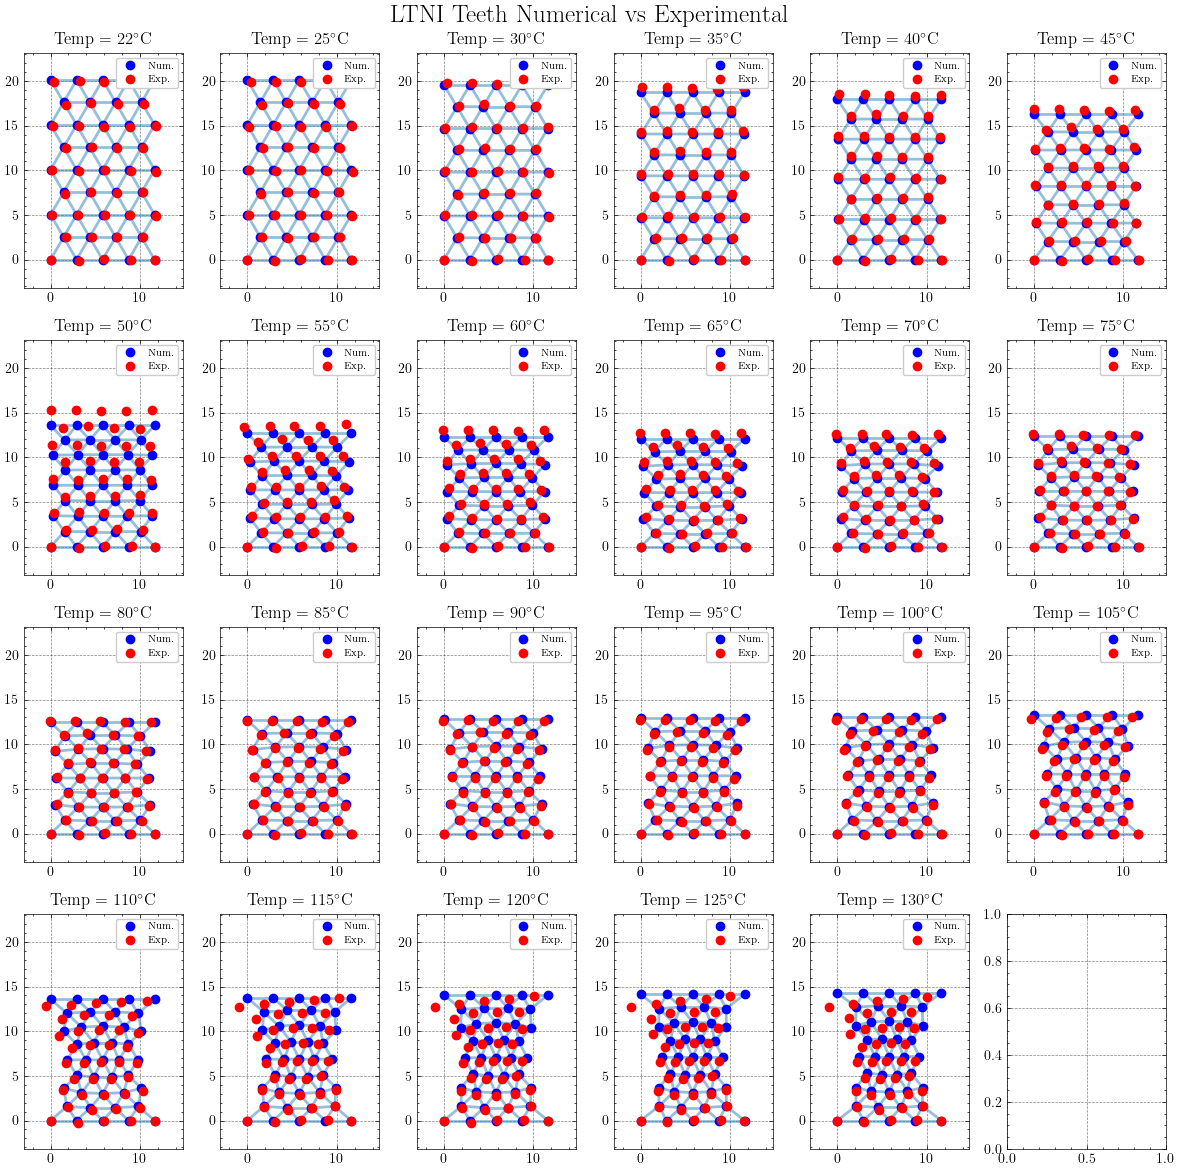

In [18]:
if lattice_topology == 'LTNI_teeth':
    fig, ax = plt.subplots(4, 6, figsize = [12, 12])

    counter = -1
    for i in jnp.arange(ax.shape[0]):
        for j in jnp.arange(ax.shape[1]):
            counter+=1

            if counter < len(sampled_temps):
                temp_i = sampled_temps[counter]
                exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
                timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

                if origin_at_central_node:
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - (lattice.control_params.reference_points[20, :] + lattice.solution[timepoint_near_temp_i, 0, 20, :])
                else:
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0]

                for pair in lattice.connectivity:
                    ax[i, j].plot(*pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

                ax[i, j].plot(pts[:, 0], pts[:, 1], 'bo', label='Num.')
                ax[i, j].plot(LTNI_teeth_x_pos[:, exp_idx_i], LTNI_teeth_y_pos[:, exp_idx_i], 'ro', label='Exp.')
                ax[i, j].set_ylim([min(LTNI_teeth_y_pos[:, 0]) - 3, max(LTNI_teeth_y_pos[:, 0]) + 3])
                ax[i, j].set_xlim([min(LTNI_teeth_x_pos[:, 0]) - 3, max(LTNI_teeth_x_pos[:, 0]) + 3])
                ax[i, j].legend(fontsize=7, loc='upper right')
                ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

    plt.suptitle('LTNI Teeth Numerical vs Experimental', fontsize=18)
    plt.tight_layout()

    dir_path = f'..\out\periodic_lattices'
    if origin_at_central_node:
        out_path_png = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_central_node_centering.png")
        out_path_svg = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_central_node_centering.svg")
    else:
        out_path_png = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_corner_node_centering.png")
        out_path_svg = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_corner_node_centering.svg")
    out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_png), dpi=200)
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

### HTNI pacman Numerical and Experimental Comparison

In [19]:
if plot_lattice_stretch_evolution and lattice_topology == 'HTNI_pacman':
    HTNI_pacman_lattice_stretch_vs_temp = jnp.zeros([2, len(sampled_temps)])
    for counter in jnp.arange(len(sampled_temps)):
        temp_i = sampled_temps[counter]
        timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

        # Calculate strain data
        top_central_node_idx = 38
        bottom_central_node_idx = 2
        left_central_node_idx = 18
        right_central_node_idx = 22

        l0_x = lattice.control_params.reference_points[right_central_node_idx, 0] - lattice.control_params.reference_points[left_central_node_idx, 0]
        l0_y = lattice.control_params.reference_points[top_central_node_idx, 1] - lattice.control_params.reference_points[bottom_central_node_idx, 1]

        l_x = (l0_x + (lattice.solution[timepoint_near_temp_i, 0, right_central_node_idx, 0] - lattice.solution[timepoint_near_temp_i, 0, left_central_node_idx, 0])) / l0_x
        l_y = (l0_y + (lattice.solution[timepoint_near_temp_i, 0, top_central_node_idx, 1] - lattice.solution[timepoint_near_temp_i, 0, bottom_central_node_idx, 1])) / l0_y

        HTNI_pacman_lattice_stretch_vs_temp = HTNI_pacman_lattice_stretch_vs_temp.at[:, counter].set(jnp.array([l_x, l_y]))


    # Plot the stretch over temperature
    plt.figure(figsize=[3,4])
    plt.plot(sampled_temps, HTNI_pacman_lattice_stretch_vs_temp[0, :], 'ko-', label='$\lambda_x$')
    plt.plot(sampled_temps, HTNI_pacman_lattice_stretch_vs_temp[1, :], color='#A52A2A', linestyle='-', marker='o', label='$\lambda_y$')
    plt.legend()
    plt.xlabel('Temperature [$^\circ$C]')
    plt.ylabel('Stretch')
    plt.title('HTNI_pacman Lattice Stretch')
    plt.tight_layout()
    np.savetxt('HTNI_pacman_lattice_stretch_vs_temp.csv', (HTNI_pacman_lattice_stretch_vs_temp[0,:], HTNI_pacman_lattice_stretch_vs_temp[1,:]), delimiter=',')

    dir_path = f'..\out\periodic_lattices'
    out_path_png = Path(f"{dir_path}/{lattice_topology}_stretch_evolution.png")
    out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_png), dpi=200)
    out_path_svg = Path(f"{dir_path}/{lattice_topology}_stretch_evolution.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

In [20]:
if lattice_topology == 'HTNI_pacman':
    fig, ax = plt.subplots(4, 6, figsize = [12, 12])

    counter = -1
    for i in jnp.arange(ax.shape[0]):
        for j in jnp.arange(ax.shape[1]):
            counter+=1

            if counter < len(sampled_temps):
                temp_i = sampled_temps[counter]
                exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
                timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

                if origin_at_central_node:
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - (lattice.control_params.reference_points[20, :] + lattice.solution[timepoint_near_temp_i, 0, 20, :])
                else:
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0]

                for pair in lattice.connectivity:
                    ax[i, j].plot(*pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

                ax[i, j].plot(pts[:, 0], pts[:, 1], 'bo', label='Num.')

                ax[i, j].plot(HTNI_pacman_x_pos[:, exp_idx_i], HTNI_pacman_y_pos[:, exp_idx_i], 'ro', label='Exp.')
                ax[i, j].set_ylim([min(HTNI_pacman_y_pos[:, 0]) - 3, max(HTNI_pacman_y_pos[:, 0]) + 3])
                ax[i, j].set_xlim([min(HTNI_pacman_x_pos[:, 0]) - 3, max(HTNI_pacman_x_pos[:, 0]) + 3])
                ax[i, j].legend(fontsize=7, loc='upper right')
                ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

    plt.suptitle('HTNI Pacman Numerical vs Experimental', fontsize=18)
    plt.tight_layout()

    dir_path = f'..\out\periodic_lattices'
    if origin_at_central_node:
        out_path_png = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_central_node_centering.png")
        out_path_svg = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_central_node_centering.svg")
    else:
        out_path_png = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_corner_node_centering.png")
        out_path_svg = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_corner_node_centering.svg")
    out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_png), dpi=200)
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

### LTNI pacman Numerical and Experimental Comparison

In [21]:
if plot_lattice_stretch_evolution and lattice_topology == 'LTNI_pacman':
    LTNI_pacman_lattice_stretch_vs_temp = jnp.zeros([2, len(sampled_temps)])
    for counter in jnp.arange(len(sampled_temps)):
        temp_i = sampled_temps[counter]
        timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

        # Calculate strain data
        top_central_node_idx = 38
        bottom_central_node_idx = 2
        left_central_node_idx = 18
        right_central_node_idx = 22

        l0_x = lattice.control_params.reference_points[right_central_node_idx, 0] - lattice.control_params.reference_points[left_central_node_idx, 0]
        l0_y = lattice.control_params.reference_points[top_central_node_idx, 1] - lattice.control_params.reference_points[bottom_central_node_idx, 1]

        l_x = (l0_x + (lattice.solution[timepoint_near_temp_i, 0, right_central_node_idx, 0] - lattice.solution[timepoint_near_temp_i, 0, left_central_node_idx, 0])) / l0_x
        l_y = (l0_y + (lattice.solution[timepoint_near_temp_i, 0, top_central_node_idx, 1] - lattice.solution[timepoint_near_temp_i, 0, bottom_central_node_idx, 1])) / l0_y

        LTNI_pacman_lattice_stretch_vs_temp = LTNI_pacman_lattice_stretch_vs_temp.at[:, counter].set(jnp.array([l_x, l_y]))


    # Plot the stretch over temperature
    plt.figure(figsize=[3,4])
    plt.plot(sampled_temps, LTNI_pacman_lattice_stretch_vs_temp[0, :], 'ko-', label='$\lambda_x$')
    plt.plot(sampled_temps, LTNI_pacman_lattice_stretch_vs_temp[1, :], color='#A52A2A', linestyle='-', marker='o', label='$\lambda_y$')
    plt.legend()
    plt.xlabel('Temperature [$^\circ$C]')
    plt.ylabel('Stretch')
    plt.title('LTNI_pacman Lattice Stretch')
    plt.tight_layout()
    np.savetxt('LTNI_pacman_lattice_stretch_vs_temp.csv', (LTNI_pacman_lattice_stretch_vs_temp[0,:], LTNI_pacman_lattice_stretch_vs_temp[1,:]), delimiter=',')

    dir_path = f'..\out\periodic_lattices'
    out_path_png = Path(f"{dir_path}/{lattice_topology}_stretch_evolution.png")
    out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_png), dpi=200)
    out_path_svg = Path(f"{dir_path}/{lattice_topology}_stretch_evolution.svg")
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

In [22]:
if lattice_topology == 'LTNI_pacman':
    fig, ax = plt.subplots(4, 6, figsize = [12, 12])
    counter = -1
    for i in jnp.arange(ax.shape[0]):
        for j in jnp.arange(ax.shape[1]):
            counter+=1

            if counter < len(sampled_temps):
                temp_i = sampled_temps[counter]
                exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
                timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

                if origin_at_central_node:
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - (lattice.control_params.reference_points[20, :] + lattice.solution[timepoint_near_temp_i, 0, 20, :])
                else:
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0]

                for pair in lattice.connectivity:
                    ax[i, j].plot(*pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

                ax[i, j].plot(pts[:, 0], pts[:, 1], 'bo', label='Num.')
                ax[i, j].plot(LTNI_pacman_x_pos[:, exp_idx_i], LTNI_pacman_y_pos[:, exp_idx_i], 'ro', label='Exp.')
                ax[i, j].set_ylim([min(LTNI_pacman_y_pos[:, 0]) - 3, max(LTNI_pacman_y_pos[:, 0]) + 3])
                ax[i, j].set_xlim([min(LTNI_pacman_x_pos[:, 0]) - 3, max(LTNI_pacman_x_pos[:, 0]) + 3])
                ax[i, j].legend(fontsize=7, loc='upper right')
                ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

    plt.suptitle('LTNI Pacman Numerical vs Experimental', fontsize=18)
    plt.tight_layout()

    dir_path = f'..\out\periodic_lattices'
    if origin_at_central_node:
        out_path_png = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_central_node_centering.png")
        out_path_svg = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_central_node_centering.svg")
    else:
        out_path_png = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_corner_node_centering.png")
        out_path_svg = Path(f"{dir_path}/{lattice_topology}_temperature_evolution_corner_node_centering.svg")
    out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_png), dpi=200)
    out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    plt.savefig(str(out_path_svg), dpi=200)

## Effective Young's modulus value for each periodic lattice (not a great match to exp data currently)

In [23]:
tensile_test_temp = sampled_temps[0]
time_at_tensile_test_temp = int(timepoints[jnp.argmin(jnp.abs(temp_evolution - tensile_test_temp))])

print('tensile_test_temp = ', tensile_test_temp)
print('time_at_tensile_test_temp = ', time_at_tensile_test_temp)

final_strain = 0.07
tensile_time_shift = 600 # 

def constrained_DOFs_fn(t):
    initial_height = (lattice.control_params.reference_points + lattice.solution[time_at_tensile_test_temp, 0])[-1, 1]
    disp_rate = initial_height*final_strain / timepoints[-1]

    constr_fn = jnp.where(
        t > tensile_time_shift,
        jnp.array([0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 
            lattice.solution[time_at_tensile_test_temp, 0, 36, 0] + 0*t, lattice.solution[time_at_tensile_test_temp, 0, 36, 1] + disp_rate*(t-tensile_time_shift), 
            lattice.solution[time_at_tensile_test_temp, 0, 37, 0] + 0*t, lattice.solution[time_at_tensile_test_temp, 0, 37, 1] + disp_rate*(t-tensile_time_shift), 
            lattice.solution[time_at_tensile_test_temp, 0, 38, 0] + 0*t, lattice.solution[time_at_tensile_test_temp, 0, 38, 1] + disp_rate*(t-tensile_time_shift), 
            lattice.solution[time_at_tensile_test_temp, 0, 39, 0] + 0*t, lattice.solution[time_at_tensile_test_temp, 0, 39, 1] + disp_rate*(t-tensile_time_shift), 
            lattice.solution[time_at_tensile_test_temp, 0, 40, 0] + 0*t, lattice.solution[time_at_tensile_test_temp, 0, 40, 1] + disp_rate*(t-tensile_time_shift)]),
       jnp.array([0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 
            lattice.solution[time_at_tensile_test_temp, 0, 36, 0], lattice.solution[time_at_tensile_test_temp, 0, 36, 1], 
            lattice.solution[time_at_tensile_test_temp, 0, 37, 0], lattice.solution[time_at_tensile_test_temp, 0, 37, 1], 
            lattice.solution[time_at_tensile_test_temp, 0, 38, 0], lattice.solution[time_at_tensile_test_temp, 0, 38, 1], 
            lattice.solution[time_at_tensile_test_temp, 0, 39, 0], lattice.solution[time_at_tensile_test_temp, 0, 39, 1], 
            lattice.solution[time_at_tensile_test_temp, 0, 40, 0], lattice.solution[time_at_tensile_test_temp, 0, 40, 1]])
    )


    return constr_fn

constrained_point_DOF_pairs=jnp.array([[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [
                                          2, 1], [3, 0], [3, 1], [4, 0], [4, 1], 
                                          [36, 0], [36, 1], [37, 0], [37, 1], [38, 0], [38, 1], [39, 0], [39, 1], [40, 0], [40, 1]])

bottom_top_nodes = jnp.array([0, 1, 2, 3, 4, 36, 37, 38, 39, 40])
top_nodes = jnp.array([36, 37, 38, 39, 40])
bottom_nodes = jnp.array([0, 1, 2, 3, 4])

# def constrained_DOFs_fn(t):
#     initial_height = (lattice.control_params.reference_points + lattice.solution[time_at_tensile_test_temp, 0])[-1, 1]
#     disp_rate = 0*initial_height*final_strain / timepoints[-1]
#     return jnp.array([0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 0*t, 0*t])

# constrained_point_DOF_pairs=jnp.array([[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [2, 1], [3, 0], [3, 1], [4, 0], [4, 1]])


def control_params_fn(t, control_params: ControlParams):
    return control_params._replace(
        young = youngs_modulus_fn(time_at_tensile_test_temp),
        thermal_strain = thermal_strain_fn(time_at_tensile_test_temp)
    )

solve_dynamics_tensile, force_fn_global_tensile = setup_dynamic_solver(
    lattice=lattice,
    control_params_fn=control_params_fn,
    constrained_DOFs_fn=constrained_DOFs_fn,
    constrained_point_DOF_pairs=constrained_point_DOF_pairs,
    # rigid_bodies_points=[jnp.arange(lattice.n_points-n1-1, lattice.n_points)],  # Last row is a rigid body
)

state_i = jnp.zeros_like(lattice.solution[time_at_tensile_test_temp])
state_i = state_i.at[0, :, :].set(lattice.solution[time_at_tensile_test_temp, 0, :, :])

# lattice.solution_tensile = solve_dynamics_tensile(lattice.solution[time_at_tensile_test_temp], timepoints, lattice.control_params)
lattice.solution_tensile = solve_dynamics_tensile(state_i, timepoints, lattice.control_params)

tensile_test_temp =  22
time_at_tensile_test_temp =  0


Effective Young's Modulus: 0.8095217313792321


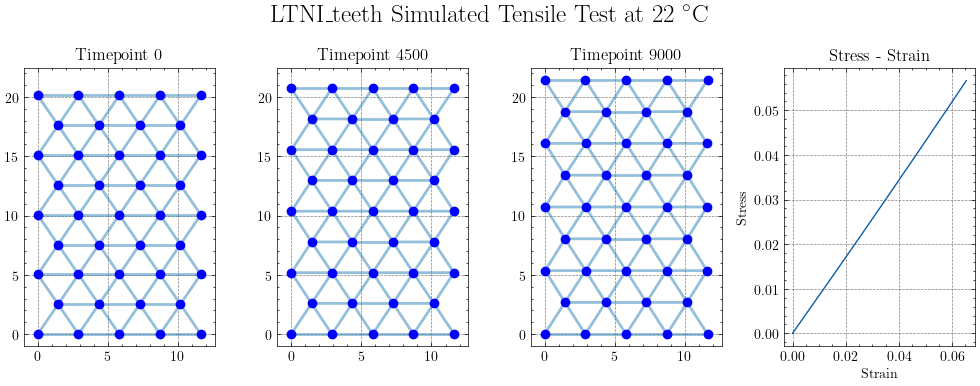

In [24]:
# DISPLACEMENT CONTROL
states_tensile = lattice.solution_tensile
rxn_force_time_space = vmap(lambda states_tensile, timepoints, control_params: force_fn_global_tensile(states_tensile, timepoints, control_params), in_axes=(0, None, None))(states_tensile, timepoints, control_params)

# calculate the force resulting from the applied displacement <9001 x 2>
rxn_force_time = (jnp.abs(jnp.sum(rxn_force_time_space[:, top_nodes, 1], axis=1)) + jnp.abs(jnp.sum(rxn_force_time_space[:, bottom_nodes, 1], axis=1)))/2

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = [10, 4])

time1 = 0
time2 = int(timepoints[-1]/2)
time3 = int(timepoints[-1])

pts1 = lattice.control_params.reference_points + lattice.solution_tensile[time1, 0]
pts2 = lattice.control_params.reference_points + lattice.solution_tensile[time2, 0]
pts3 = lattice.control_params.reference_points + lattice.solution_tensile[time3, 0]

for pair in lattice.connectivity:
    ax1.plot(*pts1[pair].T, lw=2, color="#2980b9", alpha = 0.5)
ax1.plot(pts1[:, 0], pts1[:, 1], 'bo', label='Num.')

for pair in lattice.connectivity:
    ax2.plot(*pts2[pair].T, lw=2, color="#2980b9", alpha = 0.5)
ax2.plot(pts2[:, 0], pts2[:, 1], 'bo', label='Num.')

for pair in lattice.connectivity:
    ax3.plot(*pts3[pair].T, lw=2, color="#2980b9", alpha = 0.5)
ax3.plot(pts3[:, 0], pts3[:, 1], 'bo', label='Num.')

applied_strain = (lattice.solution_tensile[tensile_time_shift:, 0, -1, 1] - lattice.solution_tensile[tensile_time_shift, 0, -1, 1]) / (lattice.control_params.reference_points[-1,1] + lattice.solution_tensile[tensile_time_shift, 0, -1, 1])

# ax4.plot(applied_strain, rxn_force_time[:, 1]/(8*control_params.area[0]))
ax4.plot(applied_strain, (rxn_force_time[tensile_time_shift:]-rxn_force_time[tensile_time_shift])/(8*control_params.area[0]))

xlim_min = jnp.min(jnp.array([jnp.min(pts1[:, 0]), jnp.min(pts2[:, 0]), jnp.min(pts3[:, 0])])) - 1
xlim_max = jnp.max(jnp.array([jnp.max(pts1[:, 0]), jnp.max(pts2[:, 0]), jnp.max(pts3[:, 0])])) + 1

ylim_min = jnp.min(jnp.array([jnp.min(pts1[:, 1]), jnp.min(pts2[:, 1]), jnp.min(pts3[:, 1])])) - 1
ylim_max = jnp.max(jnp.array([jnp.max(pts1[:, 1]), jnp.max(pts2[:, 1]), jnp.max(pts3[:, 1])])) + 1

ax1.set_title(f'Timepoint {time1}')
ax2.set_title(f'Timepoint {time2}')
ax3.set_title(f'Timepoint {time3}')
ax1.set_xlim([xlim_min, xlim_max])
ax2.set_xlim([xlim_min, xlim_max])
ax3.set_xlim([xlim_min, xlim_max])
ax1.set_ylim([ylim_min, ylim_max])
ax2.set_ylim([ylim_min, ylim_max])
ax3.set_ylim([ylim_min, ylim_max])
ax4.set_title('Stress - Strain')
ax4.set_xlabel('Strain')
ax4.set_ylabel('Stress')


plt.suptitle(f'{lattice_topology} Simulated Tensile Test at {tensile_test_temp} $^\circ$C', fontsize=18)
plt.tight_layout()

print('Effective Young\'s Modulus:', (rxn_force_time[-1]-rxn_force_time[tensile_time_shift])/(8*control_params.area[0]) / final_strain)

## Simulating Non-periodic lattices

### Trying various examples

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


n_bonds =  388


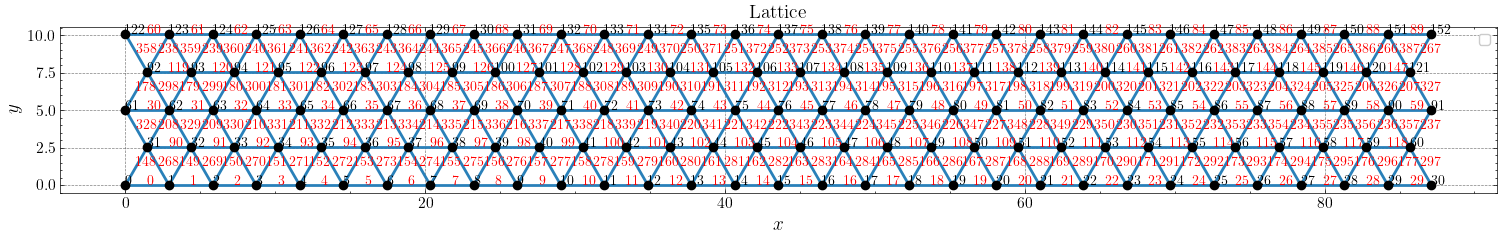

In [8]:
n1 = 30
n2 = 4 # needs to be an even number for current code. needs to be fixed # TODO

spacing = LTNI_all_x_pos[3, 0] - LTNI_all_x_pos[4, 0] # needs to be manually determined bc of inconsistent indexing in experimental data
points = triangular_lattice_points(n1=n1, n2=n2, spacing=spacing)
connectivity, horiz_bonds_even, horiz_bonds_odd, right_lean_even, right_lean_odd, left_lean_even, left_lean_odd = triangular_lattice_connectivity(n1=n1, n2=n2)

n_points = points.shape[0]
n_bonds = connectivity.shape[0]

control_params = ControlParams(
    reference_points=points,
    young=jnp.ones(n_bonds),
    area=jnp.ones(n_bonds)*(4*0.125**2),
    thermal_strain=-0.25*jnp.ones(n_bonds),
    damping=0.03*jnp.ones((n_points, 2)),
    masses=1.*jnp.ones((n_points, 2)),
)
lattice = Lattice(
    connectivity=connectivity,
    control_params=control_params
)
plot_lattice(lattice, annotate=True, figsize=(15, 5))

print('n_bonds = ', n_bonds)

### Predefined nonperiodic topologies

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Alternating HTNI Pacman'}, xlabel='$x$', ylabel='$y$'>)

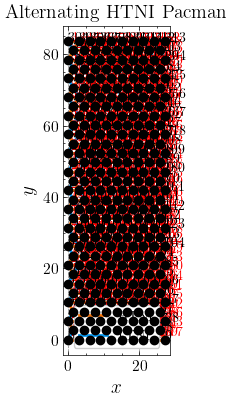

In [8]:
def nonperiodic_topologies(lattice_number):
    """Classifies the bond indices as HTNI or LTNI depending on the desired lattice topology to be simulated. Currently, this is all done manually.

    Args:
        lattice_number (int): number corresponding to the manually designed lattice topology

    Returns:
        n1 (int): Number of horizontal struts on the bottom layer that define the lattice geometry.
        n2 (int): Number of layers in the y direction of the lattice.
        LTNI_bond_indices (jnp.ndarray): array of shape (number of LTNI struts,) representing the indices of the struts with LTNI properties
        HTNI_bond_indices (jnp.ndarray): array of shape (number of HTNI struts,) representing the indices of the struts with HTNI properties
        lattice_title (str): title of the lattice describing its topology
    """
    
    if lattice_number == 0:
        num_bonds = 258
        n1 = 20
        n2 = 4
        lattice_title = 'S-Shape'
        HTNI_bond_indices = jnp.array([42, 43, 44, 45, 46, 240, 160, 241, 161, 242, 162, 243, 163, 244, 164,
                            13, 14, 15, 16, 17, 111, 191, 112, 192, 113, 193, 114, 194, 115, 195])
        
        LTNI_bond_indices = jnp.delete(jnp.arange(num_bonds), HTNI_bond_indices)

    if lattice_number == 1:
        num_bonds = 258
        n1 = 20
        n2 = 4
        lattice_title = ''
        LTNI_bond_indices = jnp.array([41, 42, 239, 159, 240, 160, 3, 4, 101, 181, 102, 182, 46, 47, 244, 164, 245, 165, 9, 10,107, 187, 108, 188,
                                       51, 52, 249, 169, 250, 170, 15, 16, 113, 193, 114, 194, 57, 58, 255, 175, 256, 176])
        
        HTNI_bond_indices = jnp.delete(jnp.arange(num_bonds), LTNI_bond_indices)

    if lattice_number == 2:
        num_bonds = 196
        n1 = 8
        n2 = 8
        lattice_title = ''
        LTNI_bond_indices = jnp.array([35, 36, 126, 191, 127, 192, 128, 193, 63, 64, 65, 158, 95, 159, 96, 160, 97, 27, 28, 183, 119, 184, 120, 57, 
                                       50, 79, 143, 80, 144, 11, 12, 102, 167, 103, 168, 104, 169, 42, 43, 44, 134, 71, 135, 72, 136, 73, 3, 4])
        
        HTNI_bond_indices = jnp.delete(jnp.arange(num_bonds), LTNI_bond_indices)
    
    if lattice_number == 3:
        num_bonds = 243
        n1 = 8
        n2 = 10
        lattice_title = ''
        LTNI_bond_indices = jnp.array([34, 148, 229, 149, 230, 70, 71, 188, 109, 189, 110, 26,
                                       140, 221, 141, 222, 63, 64, 180, 101, 181, 102, 18, 132,
                                       213, 133, 214, 56, 57, 172, 93, 173, 94, 27, 28, 142, 223,
                                       65, 182, 103, 19, 20, 37, 151, 232, 152, 233, 73, 74, 191,
                                       112, 192, 113, 29, 143, 224, 144, 225, 66, 67, 183, 104,
                                       184, 105, 21, 135, 216, 136, 217, 59, 60, 175, 96, 176, 97, 13])
        
        HTNI_bond_indices = jnp.delete(jnp.arange(num_bonds), LTNI_bond_indices)
    
    if lattice_number == 4: # Arda's "rando lattice 5"
        num_bonds = 496
        n1 = 20
        n2 = 8
        lattice_title = 'Rando Lattice 5'
        LTNI_bond_indices = jnp.array([162, 163, 164, 165, 166, 167, 168, 169, 170,
                                        66, 67, 68, 69, 70, 71, 72, 73, 321, 322, 323, 324, 325, 326, 327, 328, 329,
                                        482, 483, 484, 485, 486, 487, 488, 489, 490, 401, 402, 403, 404, 405, 406, 407,
                                        408, 409, 242, 243, 244, 245, 246, 247, 248, 249, 250, 5, 6, 7, 8, 9, 10, 11, 
                                        12, 13, 14, 105, 106, 107, 108, 109, 110, 111, 112, 113, 26, 27, 28, 29, 30, 31, 32, 
                                        33, 341, 342, 343, 344, 345, 346, 347, 348, 349, 182, 183, 184, 185, 186, 187, 188, 
                                        189, 190, 261, 262, 263, 264, 265, 266, 267, 268, 269, 422, 423, 424, 425, 426, 427, 
                                        428, 429, 430])
        
        HTNI_bond_indices = jnp.delete(jnp.arange(num_bonds), LTNI_bond_indices)

    if lattice_number == 5: # alternating LTNI pacman (mirror flip every layer)
        num_bonds = 760
        n1 = 8
        n2 = 32
        lattice_title = 'Alternating LTNI Pacman'
        _, horiz_bonds_even, horiz_bonds_odd, right_lean_even, right_lean_odd, left_lean_even, left_lean_odd = triangular_lattice_connectivity(n1=n1, n2=n2)
        LTNI_bond_indices = jnp.concatenate([jnp.arange(len(horiz_bonds_even)+len(horiz_bonds_odd)), # all horizontal bonds
                                            jnp.arange(504, 504+n1*(n2/4/2)), jnp.arange(632, 632+n1*(n2/4/2)),# left leaning first 8 rows
                                            jnp.arange(280, 280+n1*(n2/4/2)), jnp.arange(408, 408+n1*(n2/4/2)),# right leaning second 8 rows
                                            jnp.arange(568, 568+n1*(n2/4/2)), jnp.arange(696, 696+n1*(n2/4/2)),# left leaning third 8 rows
                                            jnp.arange(344, 344+n1*(n2/4/2)), jnp.arange(472, 472+n1*(n2/4/2))]).astype(int) # right leaning fourth 8 rows
                                            
        HTNI_bond_indices = jnp.delete(jnp.arange(num_bonds), jnp.sort(LTNI_bond_indices))
    
    if lattice_number == 6: # long strip bilayer lattice bottom half LTNI top half HTNI
        num_bonds = 388
        n1 = 30
        n2 = 4
        lattice_title = 'Long Strip Bilayer Lattice'
        _, horiz_bonds_even, horiz_bonds_odd, right_lean_even, right_lean_odd, left_lean_even, left_lean_odd = triangular_lattice_connectivity(n1=n1, n2=n2)
        LTNI_bond_indices = jnp.concatenate([jnp.arange(60), # first two horizontal even rows
                                            jnp.arange(90, 119), # first horizontal odd row]
                                            jnp.arange(148, 178), # first row right leaning
                                            jnp.arange(268, 298), # first row left leaning
                                            jnp.arange(328, 358), # second row left leaning
                                            jnp.arange(208, 238)]).astype(int) # right leaning fourth 8 rows
                                            
        HTNI_bond_indices = jnp.delete(jnp.arange(num_bonds), jnp.sort(LTNI_bond_indices))

    if lattice_number == 7: # Arda's "rando lattice 5" with LTNI and HTNI inverted
        num_bonds = 496
        n1 = 20
        n2 = 8
        lattice_title = 'Rando Lattice 5: HTNI and LTNI inverted'
        HTNI_bond_indices = jnp.array([162, 163, 164, 165, 166, 167, 168, 169, 170,
                                        66, 67, 68, 69, 70, 71, 72, 73, 321, 322, 323, 324, 325, 326, 327, 328, 329,
                                        482, 483, 484, 485, 486, 487, 488, 489, 490, 401, 402, 403, 404, 405, 406, 407,
                                        408, 409, 242, 243, 244, 245, 246, 247, 248, 249, 250, 5, 6, 7, 8, 9, 10, 11, 
                                        12, 13, 14, 105, 106, 107, 108, 109, 110, 111, 112, 113, 26, 27, 28, 29, 30, 31, 32, 
                                        33, 341, 342, 343, 344, 345, 346, 347, 348, 349, 182, 183, 184, 185, 186, 187, 188, 
                                        189, 190, 261, 262, 263, 264, 265, 266, 267, 268, 269, 422, 423, 424, 425, 426, 427, 
                                        428, 429, 430])
        
        LTNI_bond_indices = jnp.delete(jnp.arange(num_bonds), HTNI_bond_indices)

    if lattice_number == 8: # Arda's "rando lattice 5" with LTNI and HTNI inverted modified such that top struts match surroundings
        num_bonds = 496
        n1 = 20
        n2 = 8
        lattice_title = 'Rando Lattice 5: HTNI and LTNI inverted and modified'
        HTNI_bond_indices = jnp.array([162, 163, 164, 165, 166, 167, 168, 169, 170, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
                                        66, 67, 68, 69, 70, 71, 72, 73, 321, 322, 323, 324, 325, 326, 327, 328, 329,
                                        482, 483, 484, 485, 486, 487, 488, 489, 490, 401, 402, 403, 404, 405, 406, 407,
                                        408, 409, 242, 243, 244, 245, 246, 247, 248, 249, 250, 5, 6, 7, 8, 9, 10, 11, 
                                        12, 13, 14, 105, 106, 107, 108, 109, 110, 111, 112, 113, 26, 27, 28, 29, 30, 31, 32, 
                                        33, 341, 342, 343, 344, 345, 346, 347, 348, 349, 182, 183, 184, 185, 186, 187, 188, 
                                        189, 190, 261, 262, 263, 264, 265, 266, 267, 268, 269, 422, 423, 424, 425, 426, 427, 
                                        428, 429, 430])
        
        LTNI_bond_indices = jnp.delete(jnp.arange(num_bonds), HTNI_bond_indices)

    if lattice_number == 9: # alternating HTNI pacman iteration1 (mirror flip every layer)
        num_bonds = 760
        n1 = 8
        n2 = 32
        lattice_title = 'Alternating HTNI Pacman iteration1'
        _, horiz_bonds_even, horiz_bonds_odd, right_lean_even, right_lean_odd, left_lean_even, left_lean_odd = triangular_lattice_connectivity(n1=n1, n2=n2)
        HTNI_bond_indices = jnp.concatenate([jnp.arange(len(horiz_bonds_even)+len(horiz_bonds_odd)), # all horizontal bonds
                                            jnp.arange(504, 504+n1*(n2/4/2)), jnp.arange(632, 632+n1*(n2/4/2)),# left leaning first 8 rows
                                            jnp.arange(280, 280+n1*(n2/4/2)), jnp.arange(408, 408+n1*(n2/4/2)),# right leaning second 8 rows
                                            jnp.arange(568, 568+n1*(n2/4/2)), jnp.arange(696, 696+n1*(n2/4/2)),# left leaning third 8 rows
                                            jnp.arange(344, 344+n1*(n2/4/2)), jnp.arange(472, 472+n1*(n2/4/2))]).astype(int) # right leaning fourth 8 rows
                                            
        LTNI_bond_indices = jnp.delete(jnp.arange(num_bonds), jnp.sort(HTNI_bond_indices))
    
    if lattice_number == 10: # alternating HTNI pacman iteration2 (mirror flip every layer) (this is the one experimentally tested)
        num_bonds = 857
        n1 = 9
        n2 = 32
        lattice_title = 'Alternating HTNI Pacman'
        _, horiz_bonds_even, horiz_bonds_odd, right_lean_even, right_lean_odd, left_lean_even, left_lean_odd = triangular_lattice_connectivity(n1=n1, n2=n2)
        HTNI_bond_indices = jnp.concatenate([jnp.arange(len(horiz_bonds_even)+len(horiz_bonds_odd)), # all horizontal bonds
                                            jnp.arange(569, 569+n1*(n2/4/2)), jnp.arange(713, 713+n1*(n2/4/2)),# left leaning first 8 rows
                                            jnp.arange(317, 317+n1*(n2/4/2)), jnp.arange(461, 461+n1*(n2/4/2)),# right leaning second 8 rows
                                            jnp.arange(641, 641+n1*(n2/4/2)), jnp.arange(785, 785+n1*(n2/4/2)),# left leaning third 8 rows
                                            jnp.arange(389, 389+n1*(n2/4/2)), jnp.arange(533, 533+n1*(n2/4/2))]).astype(int) # right leaning fourth 8 rows
                                            
        LTNI_bond_indices = jnp.delete(jnp.arange(num_bonds), jnp.sort(HTNI_bond_indices))
    
        
    return n1, n2, LTNI_bond_indices, HTNI_bond_indices, lattice_title

lattice_number = 10
n1, n2, LTNI_bond_indices, HTNI_bond_indices, lattice_title = nonperiodic_topologies(lattice_number)

spacing = 1.04*(LTNI_all_x_pos[3, 0] - LTNI_all_x_pos[4, 0]) # needs to be manually determined bc of inconsistent indexing in experimental data
points = triangular_lattice_points(n1=n1, n2=n2, spacing=spacing)
connectivity, _, _, _, _, _, _ = triangular_lattice_connectivity(n1=n1, n2=n2)

timepoints = jnp.linspace(0, ts[-1], 9001)
temp_evolution = T(timepoints) # used for plotting


n_points = points.shape[0]
n_bonds = connectivity.shape[0]

control_params = ControlParams(
    reference_points=points,
    young=jnp.ones(n_bonds),
    area=jnp.ones(n_bonds)*(4*0.125**2),
    thermal_strain=-0.25*jnp.ones(n_bonds),
    damping=0.03*jnp.ones((n_points, 2)),
    masses=1.*jnp.ones((n_points, 2)),
)
lattice = Lattice(
    connectivity=connectivity,
    control_params=control_params
)
plot_lattice(lattice, title=lattice_title, annotate=True, figsize=(10, 4), LTNI_bond_indices=LTNI_bond_indices, HTNI_bond_indices=HTNI_bond_indices)

In [9]:
# Define the Young's modulus and thermal strain vectors for the nonperiodic topology
def nonperiodic_young(t):
    young = jnp.ones(n_bonds)

    young = young.at[LTNI_bond_indices].set(LTNI_young_fit_fine(T(t)))
    young = young.at[HTNI_bond_indices].set(HTNI_young_fit_fine(T(t)))

    return young

def nonperiodic_thermalstrain(t):
    thermal_strain = jnp.ones(n_bonds)

    thermal_strain = thermal_strain.at[LTNI_bond_indices].set((LTNI_stretch(T(t))-1)*0.6)
    thermal_strain = thermal_strain.at[HTNI_bond_indices].set((HTNI_stretch(T(t))-1)*0.8)

    return thermal_strain

# Initial conditions
state0 = jnp.array([
    0*lattice.control_params.reference_points,  # Initial displacements
    0*lattice.control_params.reference_points,  # Initial velocities
])

# Update the control_params_fn with the newly defined Young's modulus and thermal strain
def control_params_fn(t, control_params: ControlParams):
    return control_params._replace(
        young = nonperiodic_young(t),
        thermal_strain = nonperiodic_thermalstrain(t)
    )

solve_dynamics, _ = setup_dynamic_solver(
    lattice=lattice,
    control_params_fn=control_params_fn,
)
lattice.solution = solve_dynamics(state0, timepoints, lattice.control_params)

strain_fn = build_strain_fn(lattice.connectivity)


### Do elastic strain bond values indicate buckling?

In [ ]:
for temp_i in sampled_temps:
    timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))
    plot_lattice(lattice, lattice.solution[timepoint_near_temp_i, 0], title=f'{lattice_title}: {temp_i}$^\circ$C', figsize=(5, 10),
                bond_values=(strain_fn(lattice.control_params.reference_points, lattice.solution[timepoint_near_temp_i, 0]) + 1)/(1 + control_params_fn(timepoint_near_temp_i, control_params).thermal_strain)-1,
                legend_label='Elastic Strain', ylim=[-4, 86], xlim=([-4, 26]))

    # dir_path = f'..\out/nonperiodic_lattices/alternating_HTNI_pacman_n1_{n1}_n2_{n2}'
    # out_path = Path(f"{dir_path}/temp_{temp_i}_degC.png")
    # out_path.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
    # plt.savefig(str(out_path), dpi=200)
    # plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

### Generate an animation of the deformation

collection_bonds =  <matplotlib.collections.LineCollection object at 0x000001F9001C74C0>


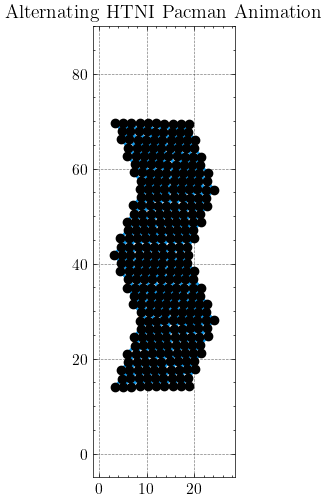

In [11]:
if lattice_number == 6:
    folder_name = 'long_strip_bilayer_n1_30_n2_4'
if lattice_number == 10:
    folder_name = 'alternating_HTNI_pacman_n1_9_n2_32'

dir_path = f'..\out/nonperiodic_lattices/nonperiodic_lattices_LTNI_alpha0.6'
out_path_anim = Path(f"{dir_path}/{folder_name}_1.04spacing_{ts[-1]}s_simtime")

# Define the bond colors as a list of blue and orange colors indexed according to the LTNI and HTNI indices
lattice_bond_colors = []
for i in jnp.arange(n_bonds):
    if i in LTNI_bond_indices:
        lattice_bond_colors.append('#069AF3')
    elif i in HTNI_bond_indices:
        lattice_bond_colors.append('#F97306')

generate_animation(
    lattice=lattice, 
    solution=lattice.solution, 
    out_filename=out_path_anim, 
    frame_range=jnp.arange(0, 9000+1, 50), 
    ylim=[-5, 90],
    figsize=[8, 5], 
    title='Alternating HTNI Pacman Animation',
    bond_color=lattice_bond_colors)

### Plot the experimental data of the bilayer or alternating HTNI pacman lattices

In [11]:
# Rotate points for Arda
if lattice_number == 10:
    experimental_x_OG = HTNIaltpac_x_pos
    experimental_y_OG = HTNIaltpac_y_pos
    nodes_for_central_plotting = jnp.array([156, 157])

    experimental_x = jnp.zeros_like(HTNIaltpac_x_pos)
    experimental_y = jnp.zeros_like(HTNIaltpac_y_pos)
    for i in jnp.arange(len(sampled_temps)):
        experimental_points = jnp.array([experimental_x_OG[:, i], experimental_y_OG[:, i]])
        rotated_experimental_points = jnp.dot(rotation_matrix(-jnp.pi/2), experimental_points)
        experimental_x = experimental_x.at[:, i].set(rotated_experimental_points[0, :])
        experimental_y = experimental_y.at[:, i].set(rotated_experimental_points[1, :])
elif lattice_number == 6:
    experimental_x = bilayer_x_pos
    experimental_y = bilayer_y_pos
    node_for_central_plotting = 76

counter =  0
counter =  1
counter =  2
counter =  3
counter =  4
counter =  5
counter =  6
counter =  7
counter =  8
counter =  9
counter =  10
counter =  11
counter =  12
counter =  13
counter =  14
counter =  15
counter =  16
counter =  17
counter =  18
counter =  19
counter =  20
counter =  21
counter =  22
counter =  23


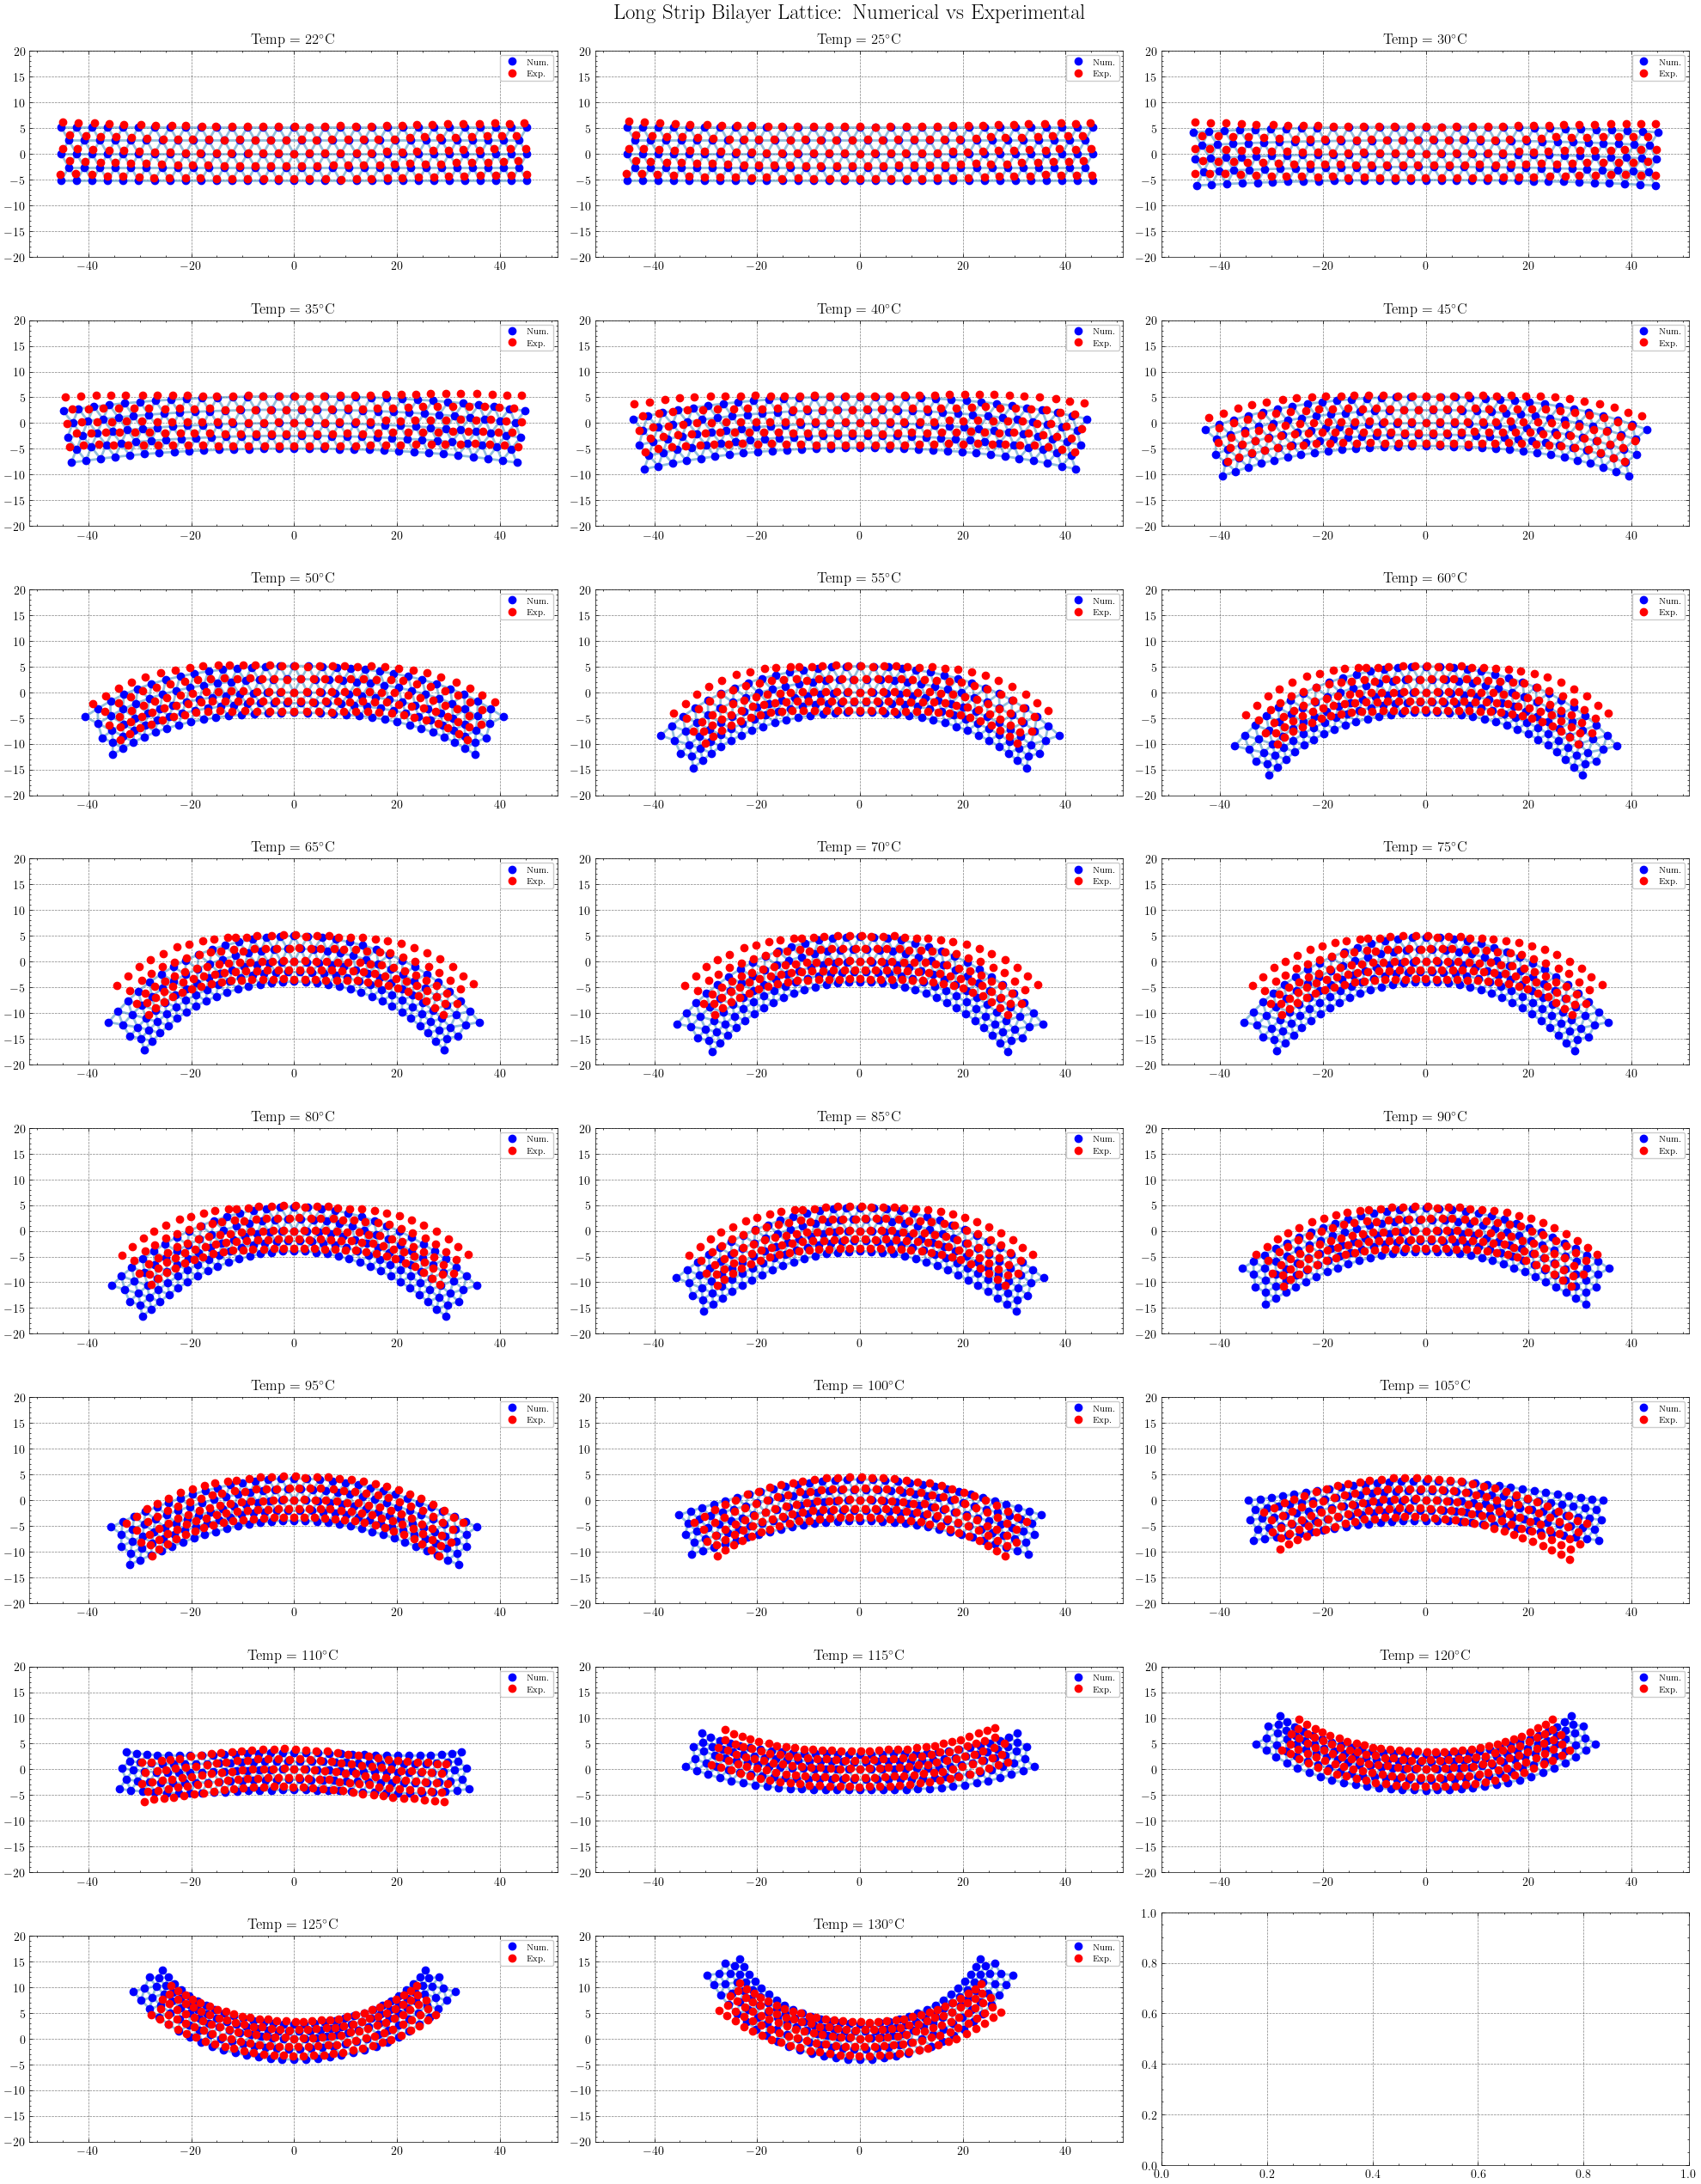

In [12]:
if lattice_number == 10:
    fig, ax = plt.subplots(8, 3, figsize = [20, 26])
else:
    fig, ax = plt.subplots(8, 3, figsize = [20, 26])

sim_sampled_timepoints = jnp.zeros(len(sampled_temps))
counter = -1
for i in jnp.arange(ax.shape[0]):
    for j in jnp.arange(ax.shape[1]):
        counter+=1

        if counter < len(sampled_temps):
            temp_i = sampled_temps[counter]
            exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
            timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))
            sim_sampled_timepoints = sim_sampled_timepoints.at[counter].set((timepoint_near_temp_i).astype(jnp.int64))

            if origin_at_central_node:
                if lattice_number == 6:
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - (lattice.control_params.reference_points[node_for_central_plotting, :] + lattice.solution[timepoint_near_temp_i, 0, node_for_central_plotting, :])
                elif lattice_number == 10:
                    xy_recentering = ((lattice.control_params.reference_points[nodes_for_central_plotting[0], :] + lattice.solution[timepoint_near_temp_i, 0, nodes_for_central_plotting[0], :]) + (lattice.control_params.reference_points[nodes_for_central_plotting[1], :] + lattice.solution[timepoint_near_temp_i, 0, nodes_for_central_plotting[1], :]))/2
                    
                    pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0] - xy_recentering
            else:
                pts = lattice.control_params.reference_points + lattice.solution[timepoint_near_temp_i, 0]


            if lattice_number == 10:
                rot_pts = jnp.dot(rotation_matrix(-jnp.pi/2), pts.T).T
                cntr_LTNI = 0
                cntr_HTNI = 0
                for k, pair in enumerate(lattice.connectivity):
                    if k in LTNI_bond_indices:
                        if cntr_LTNI == 0:
                            ax[i, j].plot(*rot_pts[pair].T, lw=2, color='#069AF3', alpha=0.5, label='LTNI')
                            cntr_LTNI = cntr_LTNI+1
                        else:
                            ax[i, j].plot(*rot_pts[pair].T, lw=2, color='#069AF3', alpha=0.5)
                    elif k in HTNI_bond_indices:
                        if cntr_HTNI == 0:
                            ax[i, j].plot(*rot_pts[pair].T, lw=2, color="#F97306", alpha=0.5, label='HTNI')
                            cntr_HTNI = cntr_HTNI+1
                        else:
                            ax[i, j].plot(*rot_pts[pair].T, lw=2, color="#F97306", alpha=0.5)

                    # ax[i, j].plot(*rot_pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

                ax[i, j].plot(rot_pts[:, 0], rot_pts[:, 1], 'bo', label='Num.')

            else:
                for pair in lattice.connectivity:
                    ax[i, j].plot(*pts[pair].T, lw=2, color="#2980b9", alpha = 0.5)

                ax[i, j].plot(pts[:, 0], pts[:, 1], 'bo', label='Num.')
            ax[i, j].plot(experimental_x[:, exp_idx_i], experimental_y[:, exp_idx_i], 'ro', label='Exp.')
            ax[i, j].set_aspect('equal', adjustable='box')
            ax[i, j].set(xlim=(min(experimental_x[:, 0]) - 6, max(experimental_x[:, 0]) + 6), ylim=(-20, 20))
            # ax[i, j].set(xlim=(min(experimental_x[:, 0]) - 6, max(experimental_x[:, 0]) + 6), ylim=(min(experimental_y[:, 0]) - 15, max(experimental_y[:, 0]) + 11))
            ax[i, j].legend(fontsize=7, loc='upper right')
            ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')
        
        if i == 11 and j == 1:
            ax[i, j].plot(0, 0, 'ro')
            ax[i, j].set_aspect('equal', adjustable='box')
            ax[i, j].set(xlim=(min(experimental_x[:, 0]) - 6, max(experimental_x[:, 0]) + 6), ylim=(min(experimental_y[:, 0]) - 15, max(experimental_y[:, 0]) + 11))
            
plt.suptitle(f'{lattice_title}: Numerical vs Experimental\n', fontsize=18)
plt.tight_layout()

if lattice_number == 6:
    folder_name = 'long_strip_bilayer_n1_30_n2_4'
if lattice_number == 10:
    folder_name = 'alternating_HTNI_pacman_n1_9_n2_32'

# dir_path = f'..\out/nonperiodic_lattices/nonperiodic_lattices_LTNI_alpha0.6'
# if origin_at_central_node:
#     out_path_png = Path(f"{dir_path}/{folder_name}_1.04spacing_{ts[-1]}s_simtime/temperature_evolution_central_node_centering_colored_struts.png")
#     out_path_svg = Path(f"{dir_path}/{folder_name}_1.04spacing_{ts[-1]}s_simtime/temperature_evolution_central_node_centering_colored_struts.svg")
# out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
# plt.savefig(str(out_path_png), dpi=200)
# out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
# plt.savefig(str(out_path_svg), dpi=200)

### Curvature of the bilayer lattice

In [14]:
sim_sampled_timepoints = sim_sampled_timepoints.astype(jnp.int64) # change the data type from uint8 to int64

# Arda's labeled left are my right because we have rotated the points
right_node_exp_idxs_imp = scipy.io.loadmat('../exp/tracking_data/bilayer/curvature_data/L_index.mat')['L_index'][0] # [mm] <num nodes x num sampled temps>
middle_node_exp_idxs_imp = scipy.io.loadmat('../exp/tracking_data/bilayer/curvature_data/M_index.mat')['M_index'][0] # [mm] <num nodes x num sampled temps>
left_node_exp_idxs_imp = scipy.io.loadmat('../exp/tracking_data/bilayer/curvature_data/R_index.mat')['R_index'][0] # [mm] <num nodes x num sampled temps>

left_node_exp_idxs = jnp.zeros(len(sampled_temps))
middle_node_exp_idxs = jnp.zeros(len(sampled_temps))
right_node_exp_idxs = jnp.zeros(len(sampled_temps))

for i in jnp.arange(len(sampled_temps)):
    left_node_exp_idxs = left_node_exp_idxs.at[i].set((left_node_exp_idxs_imp[i]-1).astype(jnp.int64))
    middle_node_exp_idxs = middle_node_exp_idxs.at[i].set((middle_node_exp_idxs_imp[i]-1).astype(jnp.int64))
    right_node_exp_idxs = right_node_exp_idxs.at[i].set((right_node_exp_idxs_imp[i]-1).astype(jnp.int64))


experimental_x = bilayer_x_pos
experimental_y = bilayer_y_pos

left_node_disps_exp = jnp.zeros([2, len(sampled_temps)])
middle_node_disps_exp = jnp.zeros([2, len(sampled_temps)])
right_node_disps_exp = jnp.zeros([2, len(sampled_temps)])
i = -1
for left_idx, middle_idx, right_idx in zip(left_node_exp_idxs, middle_node_exp_idxs, right_node_exp_idxs):
    i = i+1
    left_node_disps_exp = left_node_disps_exp.at[0, i].set(experimental_x[int(left_idx), i])
    left_node_disps_exp = left_node_disps_exp.at[1, i].set(experimental_y[int(left_idx), i])

    middle_node_disps_exp = middle_node_disps_exp.at[0, i].set(experimental_x[int(middle_idx), i])
    middle_node_disps_exp = middle_node_disps_exp.at[1, i].set(experimental_y[int(middle_idx), i])

    right_node_disps_exp = right_node_disps_exp.at[0, i].set(experimental_x[int(right_idx), i])
    right_node_disps_exp = right_node_disps_exp.at[1, i].set(experimental_y[int(right_idx), i])


left_node_sim_idx = 61
middle_node_sim_idx = 76
right_node_sim_idx = 91

left_node_disps_sim = jnp.zeros([2, len(sampled_temps)])
middle_node_disps_sim = jnp.zeros([2, len(sampled_temps)])
right_node_disps_sim = jnp.zeros([2, len(sampled_temps)])

counter = -1
for timepoint in sim_sampled_timepoints:
    counter = counter+1
    pts_ = lattice.control_params.reference_points + lattice.solution[timepoint, 0] - (lattice.control_params.reference_points[node_for_central_plotting, :] + lattice.solution[timepoint, 0, node_for_central_plotting, :])
    left_node_disps_sim = left_node_disps_sim.at[:, counter].set(pts_[left_node_sim_idx])
    middle_node_disps_sim = middle_node_disps_sim.at[:, counter].set(pts_[middle_node_sim_idx])
    right_node_disps_sim = right_node_disps_sim.at[:, counter].set(pts_[right_node_sim_idx])


def curvature(left_pos, middle_pos, right_pos):
    # left_pos: left points <2x23>
    # middle_pos: middle points <2x23>
    # right_pos: right points <2x23>
    c = jnp.zeros(left_pos.shape[1])
    for i in jnp.arange(left_pos.shape[1]):
        x_ = left_pos[:, i]
        y_ = middle_pos[:, i]
        z_ = right_pos[:, i]

        rotation_angle = -jnp.arctan((z_[1]-x_[1]) / (z_[0]-x_[0]))

        OGpts = jnp.array([x_, y_, z_])
        rot_pts = jnp.dot(rotation_matrix(rotation_angle), OGpts.T)

        x, y, z = rot_pts.T # updated x, y, z to get area between three points


        A = 0.5*(z[0] - x[0])*(x[1] - y[1]) # x[1] = z[1]

        xy_dist = jnp.linalg.norm(x-y)
        yz_dist = jnp.linalg.norm(y-z)
        zx_dist = jnp.linalg.norm(z-x)

        c = c.at[i].set(4*A / (xy_dist*yz_dist*zx_dist))

    return c

exp_curvature = curvature(left_node_disps_exp, middle_node_disps_exp, right_node_disps_exp)
sim_curvature = curvature(left_node_disps_sim, middle_node_disps_sim, right_node_disps_sim)

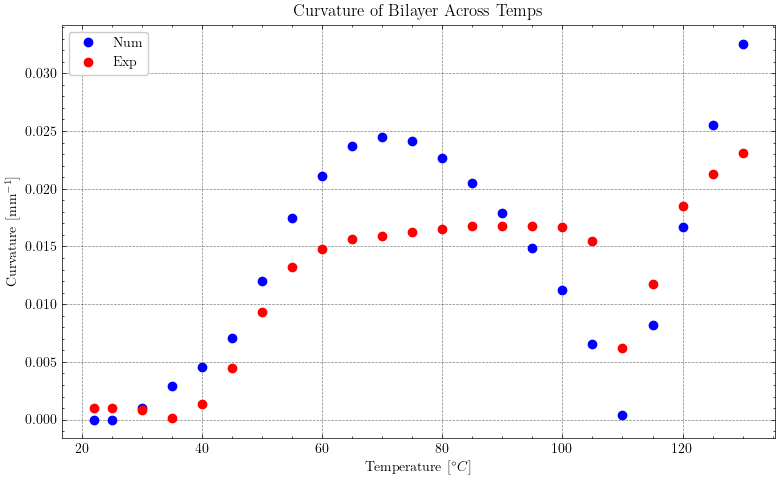

In [15]:
plt.figure(figsize=[8,5])
plt.plot(sampled_temps, sim_curvature, 'bo', label='Num')
plt.plot(sampled_temps, exp_curvature, 'ro', label='Exp')
plt.xlabel('Temperature [$^\circ C$]')
plt.ylabel('Curvature [mm$^{-1}$]')
plt.legend()
plt.title('Curvature of Bilayer Across Temps')
plt.tight_layout()


# dir_path = f'..\out/nonperiodic_lattices/nonperiodic_lattices_LTNI_alpha0.6'
# if origin_at_central_node:
#     out_path_png = Path(f"{dir_path}/{folder_name}_1.04spacing_{ts[-1]}s_simtime/curvature_evolution.png")
#     out_path_svg = Path(f"{dir_path}/{folder_name}_1.04spacing_{ts[-1]}s_simtime/curvature_evolution.svg")
# out_path_png.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
# plt.savefig(str(out_path_png), dpi=200)
# out_path_svg.parent.mkdir(parents=True, exist_ok=True)  # Make sure parents directories exist
# plt.savefig(str(out_path_svg), dpi=200)